# CMS Open Payments Anomaly Detection

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Dataset:** CMS Open Payments Program Year 2024 General Payments  
**Objective:** End-to-end pipeline for detecting anomalous healthcare payment patterns

## Team Members - Group 3
1. Swapnil Patil
2. Jamshed Nabizada
3. Tej Singh Bahadur

# Objective
 - To Develop an end to end anomaly detection pipeline for the CMS Open Payments (General Payments) dataset to identify potentially unusual or high risk payment patterns.

- Clean and engineer features (payment amounts, recipients, geography, time, payment nature) to create a model-ready dataset at scale.

- Train and compare multiple anomaly detection approaches (e.g., Isolation Forest, Autoencoder, XGBoost-based scoring) and evaluate how well they surface meaningful outliers.

- Produce interpretable risk scores and visual outputs to support compliance, auditing, and downstream monitoring/MLOps deployment.

- Implement an end to end MLOps workflow that operationalizes the anomaly models, including reproducible data ingestion from the data lake, automated preprocessing/feature generation, model training, and versioned artifact storage.

- Enable continuous monitoring for data drift and anomaly-rate shifts, with scheduled retraining, CI/CD-based deployment, and alerting dashboards to support ongoing compliance and audit workflows.

# Dataset
The CMS Open Payments dataset provides detailed information about financial transactions between healthcare providers and pharmaceutical/medical device companies. The dataset includes various attributes such as payment amounts, recipient details, payment nature, and geographic information. This rich dataset allows for comprehensive analysis to identify potentially anomalous payment patterns that may indicate compliance issues or fraudulent activities.

Primary dataset: Open Payments Program Year 2024 (General Payments). PY2024 was published June 30, 2025, and covers payments made between January 1 and December 31, 2024. CMS reports PY2024 includes approximately 16.16 million records totaling $13.18B in payments/transfers of value, and the site reflects the most recent seven years of data (CMS, 2025a).

NOTE: The dataset is large and due to AWS credit limitations, we will be working with a subset of the data (e.g., 1 million records) for the purposes of this project. The workflow and code will be designed to scale to the full dataset when resources allow.

Dataset source: [CMS Open Payments Data](https://openpaymentsdata.cms.gov/dataset/e6b17c6a-2534-4207-a4a1-6746a14911ff#data-table)

## Data Privacy & Ethics
Because Open Payments is public, it typically does not include clinical details (PHI), but it can still contain identifiable information (PII) about covered recipients and related entities, so it should be handled as sensitive. The data subjects are physicians and non-physician practitioners; the data types include names/identifiers, location fields, payer/manufacturer info, payment amount/date, and payment category. CMS collects and publishes the dataset, while the project team ingests and uses it (e.g., via S3/Athena) to generate anomaly scores for compliance-style review. Storage and processing should follow least-privilege access, encryption in transit/at rest, data minimization (only required columns), controlled logging, and retention rules, with outputs ideally using pseudonymous identifiers where possible.

## Table of Contents

### Setup & Configuration
- [1. Environment Setup](#1-environment-setup)
- [2. AWS Configuration & Datalake Setup](#2-aws-configuration--datalake-setup)

### Data Preparation
- [3. Data Loading & Exploration](#3-data-loading--exploration)
- [4. Data Cleaning & Preprocessing](#4-data-cleaning--preprocessing)

### Analysis & Features
- [5. Exploratory Data Analysis](#5-exploratory-data-analysis)
  - Payment Statistics
  - Recipient Type Analysis
  - State-Level Analysis
  - Temporal Trend Analysis
  - Interpretation of the Exploratory Data Analysis
- [6. Feature Engineering](#6-feature-engineering)
  - Data Splitting
  - Historical Features
  - Risk Indicators

### Model Training
- [7. Isolation Forest Model Training](#7-isolation-forest-model-training)
  - Data Preparation
  - Model Training
  - Anomaly Detection
  - Performance Evaluation
  - Anomaly Analysis by Payment Amount
  - Training Performance Statistics
  - Interpretation of Isolation Forest Results
- [8. Autoencoder Model Training](#8-autoencoder-model-training)
  - Architecture Design
  - Training with Early Stopping
  - Reconstruction Error Analysis
  - Visualization
  - Interpretation of Autoencoder Results
- [9. XGBoost Model Training](#9-xgboost-model-training)
  - Pseudo-Label Generation
  - Model Configuration
  - Training & Evaluation
  - Feature Importance
  - Interpretation of XGBoost Results

### Optimization & Deployment
- [10. Hyperparameter Tuning](#10-hyperparameter-tuning)
  - Grid Search
  - Randomized Search
  - Model Comparison
  - Hyperparameter Tuning Summary
  - Interpretation of Hyperparameter Tuning Results
- [11. Model Deployment to SageMaker](#11-model-deployment-to-sagemaker)
  - Package Model Artifacts
  - Model Registry
  - Model Card
  - Deploy Endpoint with Data Capture
  - Test Endpoint
  - Generate Baseline for Monitoring
  - Model Quality Monitoring
  - CloudWatch Alarms
  - Deployment Summary
  - Model Deployment and MLOps

### Analysis & Recommendations
- [Model Bias and Monitoring](#model-bias-and-monitoring)
- [Future Improvements & Next Steps](#future-improvements--next-steps)
- [Conclusion](#conclusion)
- [References](#references)

---

## 1. Environment Setup

In [1]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [67]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import joblib
import tarfile
import sys
from pathlib import Path
from datetime import datetime

import boto3
import sagemaker
import awswrangler as wr
from pyathena import connect
from sagemaker import get_execution_role, Session
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, roc_auc_score
from scipy.stats import randint, uniform

from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from utils.visualizations import PaymentVisualizer, ModelVisualizer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

visualizer = PaymentVisualizer()
model_viz = ModelVisualizer()

## 2. AWS Configuration & Datalake Setup

This section establishes the cloud data foundation for the project by configuring AWS services required to store, query, and scale Open Payments data processing. It sets up S3 as the data lake storage layer and uses Athena (via boto3) to create the database/external tables and run SQL queries directly on the files. The workflow also supports converting raw CSV inputs into analytics-friendly Parquet (optionally partitioned by program year) to improve query performance, reduce cost, and ensure the dataset can be reliably accessed for downstream feature engineering, model training, and MLOps automation.

In [3]:
boto_session = boto3.Session()
region = boto_session.region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity().get('Account')

s3_client = boto3.client('s3', region_name=region)
s3_resource = boto3.resource('s3')

dataset_file_name = "lightdataset.csv"
bucket = f"cmsopenpaymentsystemslight"
cms_data_prefix = "cms-open-payments-light"
database_name = "cms_open_payments_light"

raw_data_prefix = f"{cms_data_prefix}/raw"
parquet_data_prefix = f"{cms_data_prefix}/parquet"

s3_raw_path = f"s3://{bucket}/{raw_data_prefix}"
s3_parquet_path = f"s3://{bucket}/{parquet_data_prefix}"
s3_athena_staging = f"s3://{bucket}/athena/staging"

table_name_csv = "general_payments_csv"
table_name_parquet = "general_payments_parquet"

In [4]:
def check_bucket_exists(bucket_name):
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        return True
    except:
        return False

def ensure_bucket_exists(bucket_name, region):
    try:
        if check_bucket_exists(bucket_name):
            return True
        if region == 'us-east-1':
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
            )
        return True
    except Exception as e:
        return False

ensure_bucket_exists(bucket, region)

True

In [5]:
athena_conn = connect(region_name=region, s3_staging_dir=s3_athena_staging)

create_db_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"
pd.read_sql(create_db_query, athena_conn)

""


In [6]:
# Check if dataset file exists in S3
s3_raw_file_key = f"{raw_data_prefix}/{dataset_file_name}"
s3_raw_file_path = f"{s3_raw_path}/{dataset_file_name}"

try:
    s3_response = s3_client.head_object(Bucket=bucket, Key=s3_raw_file_key)
    file_size_mb = s3_response['ContentLength'] / (1024**2)
except Exception as e:
    pass

In [7]:
# Verify S3 file is accessible for Athena table creation
try:
    s3_client.head_object(Bucket=bucket, Key=s3_raw_file_key)
except Exception as e:
    raise

In [8]:
# Check if CSV table already exists and has data
try:
    check_csv_table = f"SELECT COUNT(*) as cnt FROM {database_name}.{table_name_csv} LIMIT 1"
    csv_result = pd.read_sql(check_csv_table, athena_conn)
    csv_exists = True
except Exception as e:
    csv_exists = False

if not csv_exists:
    # Read schema from S3 dataset file
    df_schema = pd.read_csv(s3_raw_file_path, nrows=1000)

    TEXT_COLUMN_PATTERNS = [
        '_name', '_address', '_city', '_state', '_country', '_province',
        '_zip', '_postal', '_code', '_ccn', '_npi', '_id', 
        'first_name', 'last_name', 'middle_name', 'suffix',
        'street', 'covered_recipient_type', 'nature_of', 'form_of',
        'physician_specialty', 'recipient_primary_', 'business_street',
        'teaching_hospital', 'applicable_manufacturer', 'making_payment'
    ]

    def get_athena_type(col_name, dtype):
        col_lower = col_name.lower()
        if any(pattern in col_lower for pattern in TEXT_COLUMN_PATTERNS):
            return 'STRING'
        if pd.api.types.is_integer_dtype(dtype):
            return 'BIGINT'
        elif pd.api.types.is_float_dtype(dtype):
            return 'DOUBLE'
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return 'TIMESTAMP'
        else:
            return 'STRING'

    columns_def = []
    for col in df_schema.columns:
        athena_type = get_athena_type(col, df_schema[col].dtype)
        columns_def.append(f"`{col}` {athena_type}")

    columns_str = ',\n    '.join(columns_def)

    create_table_query = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_csv} (
        {columns_str}
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    STORED AS TEXTFILE
    LOCATION '{s3_raw_path}/'
    TBLPROPERTIES (
        'skip.header.line.count'='1',
        'serialization.null.format'=''
    )
    """

    pd.read_sql(create_table_query, athena_conn)
    print(f"Table created: {table_name_csv}")
else:
    print(f"Skipping CSV table creation - table already exists")

Skipping CSV table creation - table already exists


In [9]:
# Check if Parquet table already exists and has data
try:
    check_parquet_query = f"SELECT COUNT(*) as row_count FROM {database_name}.{table_name_parquet}"
    parquet_result = pd.read_sql(check_parquet_query, athena_conn)
    parquet_row_count = parquet_result['row_count'][0]
    parquet_exists = parquet_row_count > 0
except Exception as e:
    parquet_exists = False

In [10]:
if not parquet_exists:
    columns_query = f"SELECT * FROM {database_name}.{table_name_csv} LIMIT 1"

    force_string_cols = [
        'teaching_hospital_ccn', 'teaching_hospital_id',
        'applicable_manufacturer_or_applicable_gpo_making_payment_id',
        'covered_recipient_npi', 'covered_recipient_profile_id',
        'physician_profile_id', 'recipient_zip_code', 'recipient_postal_code'
    ]

    columns_df = pd.read_sql(columns_query, athena_conn)
    columns = columns_df.columns.tolist()

    if 'program_year' in columns:
        columns.remove('program_year')

    formatted_columns = []
    for col in columns:
        if col in force_string_cols or any(pattern in col.lower() for pattern in 
            ['_name', '_address', '_city', '_id', '_npi', '_ccn', 'zip', 'postal']):
            formatted_columns.append(f'CAST("{col}" AS VARCHAR) AS "{col}"')
        else:
            formatted_columns.append(f'"{col}"')

    columns_str = ',\n '.join(formatted_columns)

    create_parquet_query = f"""
    CREATE TABLE {database_name}.{table_name_parquet}
    WITH (
        format = 'PARQUET',
        parquet_compression = 'SNAPPY',
        external_location = '{s3_parquet_path}/',
        partitioned_by = ARRAY['program_year']
    )
    AS
    SELECT 
        {columns_str},
        '2024' as program_year
    FROM {database_name}.{table_name_csv}
    """

    print("Converting to Parquet...")
    pd.read_sql(create_parquet_query, athena_conn)
    print(f"Parquet table created: {table_name_parquet}")
else:
    print("Skipping Parquet conversion - using existing data")

Skipping Parquet conversion - using existing data


In [11]:
result = pd.read_sql(
    f"SELECT COUNT(*) as row_count FROM {database_name}.{table_name_parquet}",
    athena_conn
)
print(f"Data verified: {result['row_count'][0]:,} rows")

Data verified: 1,000,000 rows


## 3. Data Loading & Exploration

This section focuses on pulling a working dataset from the AWS data lake into a pandas dataframe and performing an initial sanity check before deeper preprocessing and modeling. Records are retrieved via Athena queries (often with a controlled sample size to keep iteration fast), then basic inspections such as row/column counts, previewing top rows, and verifying key fields (amounts, dates, identifiers, categorical values, missingness) are performed. The outcome is a validated, analysis-ready dataframe and an early understanding of data quality and distributions, which directly informs the cleaning rules and feature engineering decisions in the next steps.

In [12]:
sample_size = 1_000_000

sample_query = f"""
SELECT *
FROM {database_name}.{table_name_parquet}
LIMIT {sample_size}
"""

df = wr.athena.read_sql_query(
    sql=sample_query,
    database=database_name,
    ctas_approach=False
)

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
display(df.head(3))

2026-02-16 01:20:58,789	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1909424128 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.60gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2026-02-16 01:20:59,987	INFO worker.py:1852 -- Started a local Ray instance.


Data loaded: 1,000,000 rows, 91 columns


,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,covered_recipient_name_suffix,recipient_primary_business_street_address_line1,recipient_primary_business_street_address_line2,recipient_city,recipient_state,recipient_zip_code,recipient_country,recipient_province,recipient_postal_code,covered_recipient_primary_type_1,covered_recipient_primary_type_2,covered_recipient_primary_type_3,covered_recipient_primary_type_4,covered_recipient_primary_type_5,covered_recipient_primary_type_6,...,indicate_drug_or_biological_or_device_or_medical_supply_2,product_category_or_therapeutic_area_2,name_of_drug_or_biological_or_device_or_medical_supply_2,associated_drug_or_biological_ndc_2,associated_device_or_medical_supply_pdi_2,covered_or_noncovered_indicator_3,indicate_drug_or_biological_or_device_or_medical_supply_3,product_category_or_therapeutic_area_3,name_of_drug_or_biological_or_device_or_medical_supply_3,associated_drug_or_biological_ndc_3,associated_device_or_medical_supply_pdi_3,covered_or_noncovered_indicator_4,indicate_drug_or_biological_or_device_or_medical_supply_4,product_category_or_therapeutic_area_4,name_of_drug_or_biological_or_device_or_medical_supply_4,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.1049966E7,1.518263342E9,<NA>,<NA>,<NA>,<NA>,1265 UPPER HEMBREE RD,<NA>,ROSWELL,GA,<NA>,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
1,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.0512664E7,1.528345469E9,<NA>,<NA>,<NA>,<NA>,103 Allen St,<NA>,Jamestown,NY,14701,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
2,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.0844269E7,1.760831846E9,<NA>,<NA>,<NA>,<NA>,365 MONTAUK AVE,<NA>,NEW LONDON,CT,<NA>,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024


## 4. Data Cleaning & Preprocessing

This section prepares the Open Payments dataset for modeling by standardizing formats, handling missing/invalid values, and converting raw fields into consistent, machine readable features. It performs data type corrections (numeric payment amounts, date parsing, indicator flag normalization), de-duplication and filtering of problematic rows, and imputation for nulls in both numeric and categorical columns. It also engineers time-based features (year, month, quarter, day-of-week, weekend flag) and organizes features into logical groups (payment, recipient, geography, nature/category), resulting in a clean, model-ready table suitable for anomaly detection and downstream risk scoring.

In [13]:
CORE_PAYMENT_FEATURES = [
    'total_amount_of_payment_usdollars',
    'number_of_payments_included_in_total_amount',
    'date_of_payment'
]

CATEGORICAL_FEATURES = [
    'covered_recipient_type',
    'nature_of_payment_or_transfer_of_value',
    'form_of_payment_or_transfer_of_value',
    'physician_specialty',
    'recipient_state'
]

IDENTIFIER_FEATURES = [
    'covered_recipient_profile_id',
    'covered_recipient_npi',
    'applicable_manufacturer_or_applicable_gpo_making_payment_name'
]

RISK_INDICATOR_FEATURES = [
    'physician_ownership_indicator',
    'third_party_payment_recipient_indicator',
    'product_indicator'
]

all_selected_features = (CORE_PAYMENT_FEATURES + CATEGORICAL_FEATURES + 
                         IDENTIFIER_FEATURES + RISK_INDICATOR_FEATURES)

available_features = [f for f in all_selected_features if f in df.columns]
df_selected = df[available_features].copy()

print(f"Features selected: {df_selected.shape}")

Features selected: (1000000, 12)


In [14]:
if 'total_amount_of_payment_usdollars' in df_selected.columns:
    df_selected['total_amount_of_payment_usdollars'] = pd.to_numeric(
        df_selected['total_amount_of_payment_usdollars'], errors='coerce'
    ).abs()

if 'date_of_payment' in df_selected.columns:
    df_selected['date_of_payment'] = pd.to_datetime(df_selected['date_of_payment'], errors='coerce')

if 'number_of_payments_included_in_total_amount' in df_selected.columns:
    df_selected['number_of_payments_included_in_total_amount'] = pd.to_numeric(
        df_selected['number_of_payments_included_in_total_amount'], errors='coerce'
    ).fillna(1).astype('int64')

indicator_mapping = {'Yes': 1, 'Y': 1, 'No': 0, 'N': 0, 'Unknown': 0}
for col in RISK_INDICATOR_FEATURES:
    if col in df_selected.columns and df_selected[col].dtype == 'object':
        df_selected[col] = df_selected[col].map(indicator_mapping).fillna(0).astype('int64')

if 'recipient_state' in df_selected.columns:
    df_selected['recipient_state'] = df_selected['recipient_state'].str.upper().str.strip()

print("Data types converted")

Data types converted


In [15]:
if 'total_amount_of_payment_usdollars' in df_selected.columns:
    payment_median = df_selected['total_amount_of_payment_usdollars'].median()
    df_selected['total_amount_of_payment_usdollars'].fillna(payment_median, inplace=True)

if 'date_of_payment' in df_selected.columns:
    df_selected['date_of_payment'].fillna(method='ffill', inplace=True)
    df_selected['date_of_payment'].fillna(method='bfill', inplace=True)

for col in df_selected.select_dtypes(include=['object']).columns:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col].fillna("Unknown", inplace=True)

for col in df_selected.select_dtypes(include=[np.number]).columns:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col].fillna(df_selected[col].median(), inplace=True)

print("Missing values handled")

Missing values handled


In [16]:
records_before = len(df_selected)

df_selected = df_selected.drop_duplicates()

if 'total_amount_of_payment_usdollars' in df_selected.columns:
    df_selected = df_selected[df_selected['total_amount_of_payment_usdollars'] > 0]

if 'date_of_payment' in df_selected.columns:
    df_selected = df_selected[df_selected['date_of_payment'].notnull()]

if 'covered_recipient_profile_id' in df_selected.columns:
    df_selected = df_selected[df_selected['covered_recipient_profile_id'].notnull()]

df_selected = df_selected.reset_index(drop=True)
records_after = len(df_selected)

print(f"Records: {records_after:,} | Removed: {records_before - records_after:,} | Retention: {records_after/records_before*100:.2f}%")

df = df_selected.copy()

Records: 997,362 | Removed: 2,638 | Retention: 99.74%


In [17]:
payment_date_col = 'date_of_payment'
if payment_date_col in df.columns:
    df['payment_year'] = df[payment_date_col].dt.year
    df['payment_month'] = df[payment_date_col].dt.month
    df['payment_quarter'] = df[payment_date_col].dt.quarter
    df['payment_dayofweek'] = df[payment_date_col].dt.dayofweek
    df['is_weekend'] = (df[payment_date_col].dt.dayofweek >= 5).astype('int64')

print("Temporal features created")

Temporal features created


## 5. Exploratory Data Analysis

This section explores the cleaned dataset to understand distributions, outliers, and key drivers of variation (amounts, recipient types, payment categories, geography, and time trends).

In [18]:
payment_col = 'total_amount_of_payment_usdollars'

if payment_col in df.columns:
    payment_stats = df[payment_col].describe()
    
    print(f"Payment Statistics:")
    print(f"Count: {payment_stats['count']:,.0f} | Mean: ${payment_stats['mean']:,.2f} | Median: ${payment_stats['50%']:,.2f}")
    print(f"Min: ${payment_stats['min']:,.2f} | Max: ${payment_stats['max']:,.2f}")
    print(f"Skewness: {df[payment_col].skew():.2f}")

Payment Statistics:
Count: 997,362 | Mean: $4,511,992.08 | Median: $20.02
Min: $0.01 | Max: $100,000,966,856.00
Skewness: 148.86


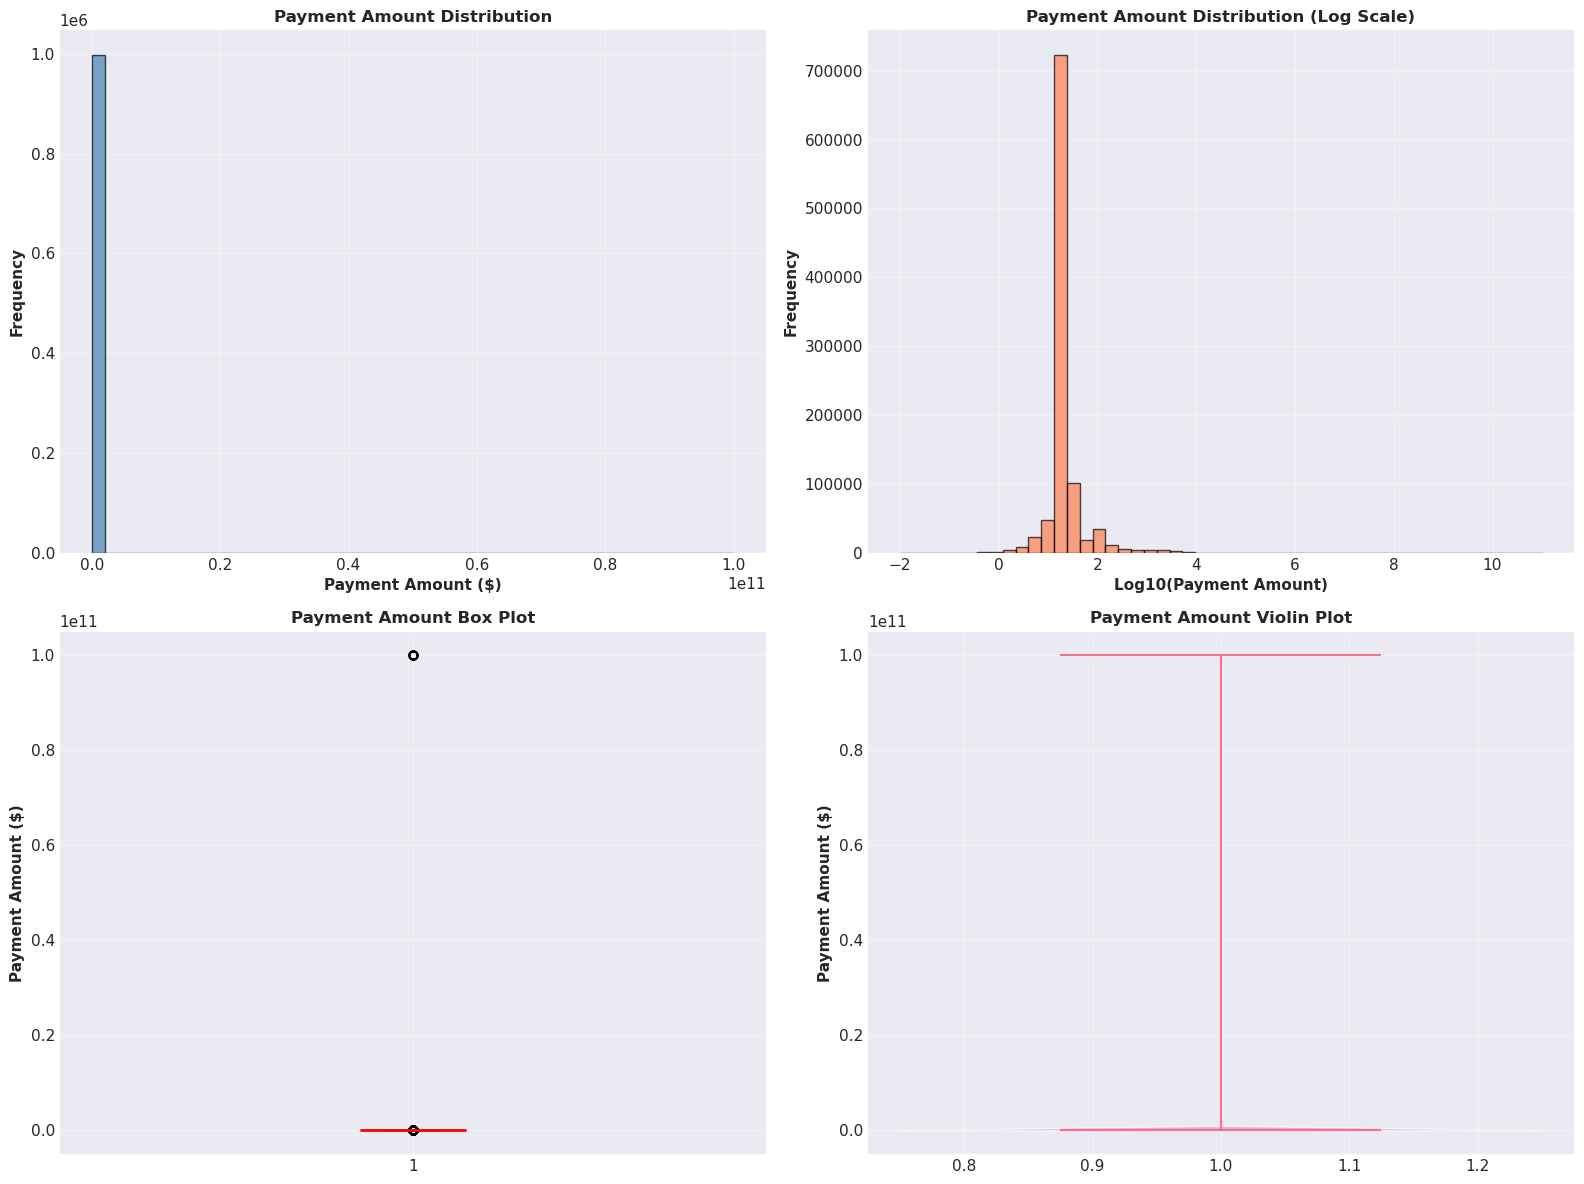

In [19]:
visualizer.plot_payment_distribution_detailed(df, payment_col=payment_col)
plt.show()

In [20]:
recipient_type_col = 'covered_recipient_type'

if recipient_type_col in df.columns and payment_col in df.columns:
    type_stats = df.groupby(recipient_type_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    type_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    type_stats = type_stats.sort_values('Total ($)', ascending=False)
    display(type_stats)

,Count,Total ($),Mean ($),Median ($)
covered_recipient_type,,,,
Covered Recipient Physician,641852,2800074825004.61,4362492.95,20.02
Covered Recipient Non-Physician Practitioner,355510,1700014614929.78,4781903.79,20.02


In [21]:
state_col = 'recipient_state'

if state_col in df.columns and payment_col in df.columns:
    state_stats = df.groupby(state_col)[payment_col].agg([
        'count', 'sum', 'mean'
    ]).round(2)
    state_stats.columns = ['Count', 'Total ($)', 'Mean ($)']
    state_stats = state_stats.sort_values('Total ($)', ascending=False).head(10)
    display(state_stats)

,Count,Total ($),Mean ($)
recipient_state,,,
"06360""",9,800002923584.02,88889213731.56
7B,13,800000017627.10,61538462894.39
420,6,400000001071.04,66666666845.17
120,9,300000152226.12,33333350247.35
3RD FLOOR,3,200000787634.02,66666929211.34
"""YALE UNIVERSITY",2,200000021166.00,100000010583.00
124,2,200000000402.00,100000000201.00
JOHNS CREEK,1,100000226817.00,100000226817.00
ACB,1,100000216794.00,100000216794.00


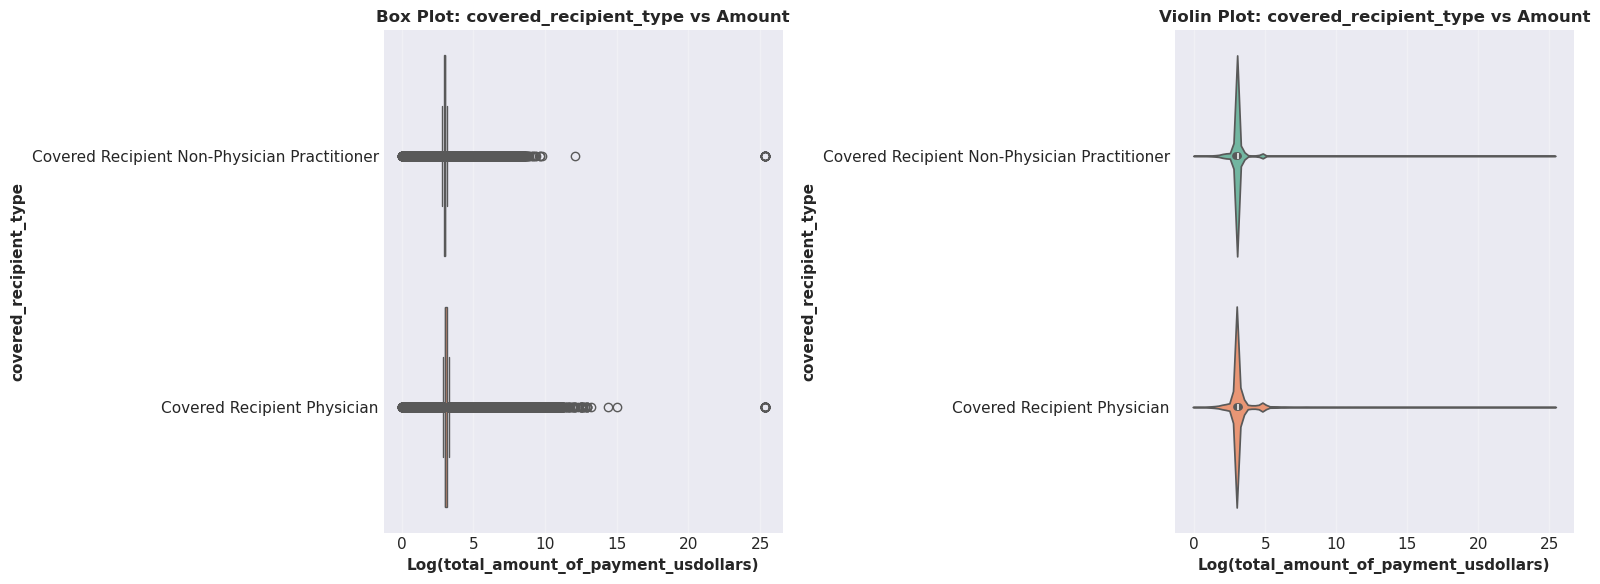

In [22]:
if recipient_type_col in df.columns and payment_col in df.columns:
    visualizer.plot_bivariate_comparison(df, group_col=recipient_type_col, amount_col=payment_col)
    plt.show()

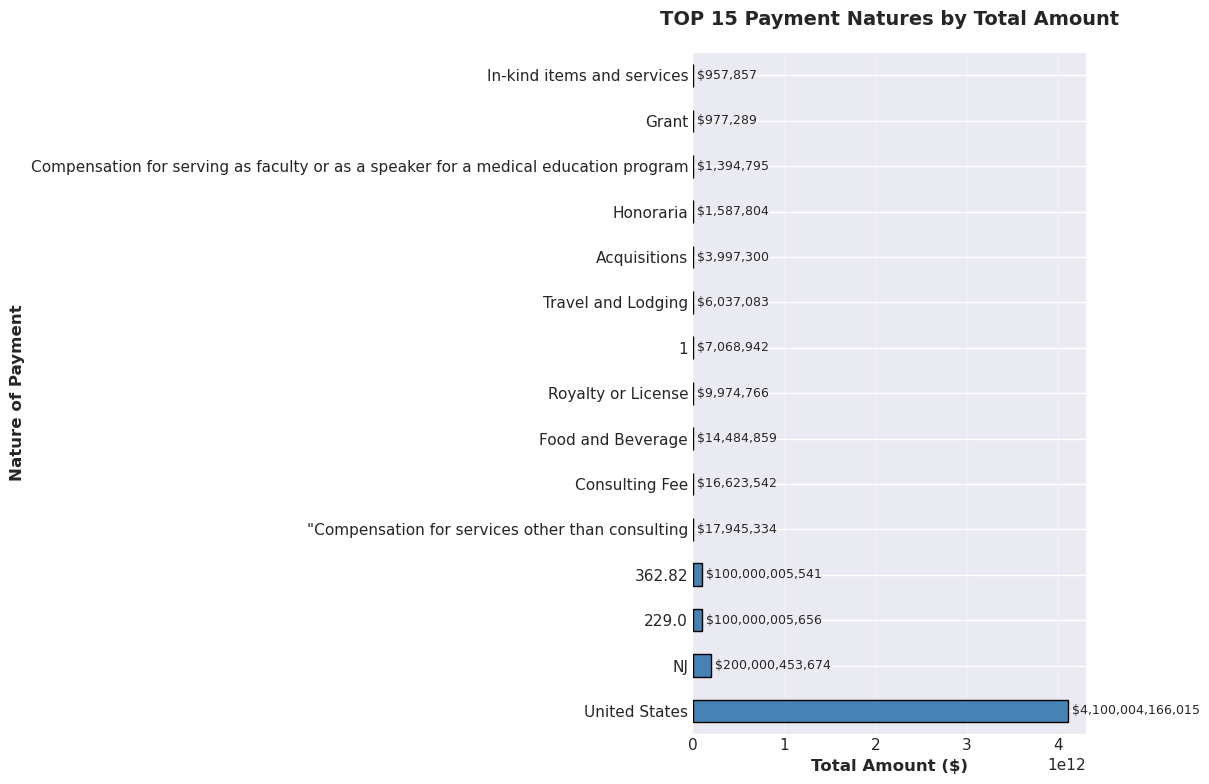

In [23]:
nature_col = 'nature_of_payment_or_transfer_of_value'

if nature_col in df.columns and payment_col in df.columns:
    visualizer.plot_payment_nature_by_total(
        df,
        nature_col=nature_col,
        amount_col=payment_col,
        top_n=15
    )
    plt.show()

### Temporal Trend Analysis

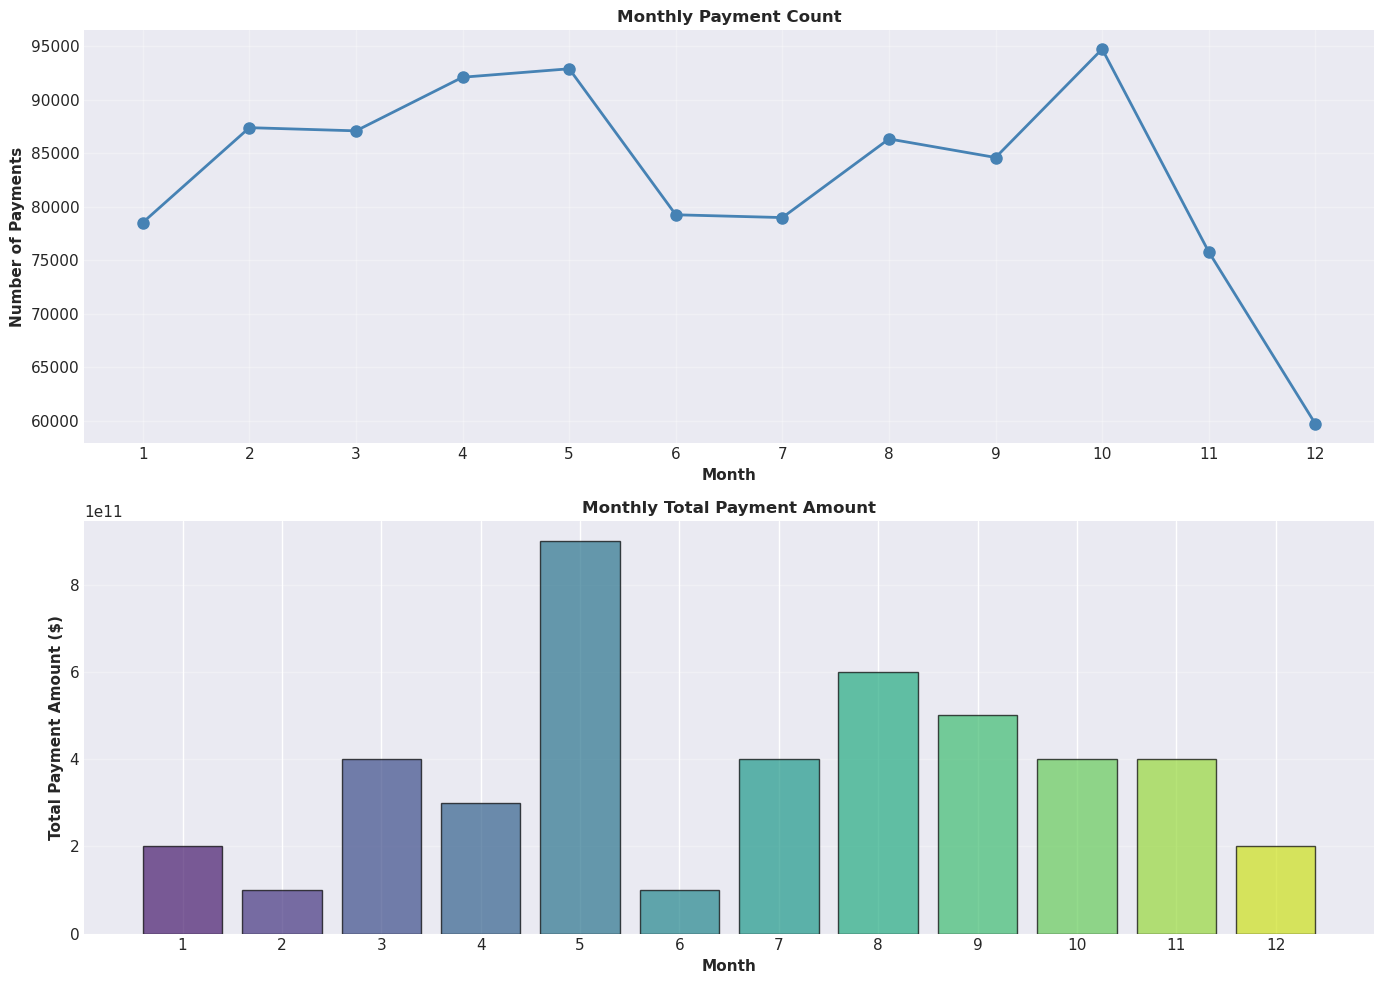

In [24]:
if 'payment_month' in df.columns and payment_col in df.columns:
    visualizer.plot_monthly_trends(df, payment_col=payment_col, month_col='payment_month')
    plt.show()

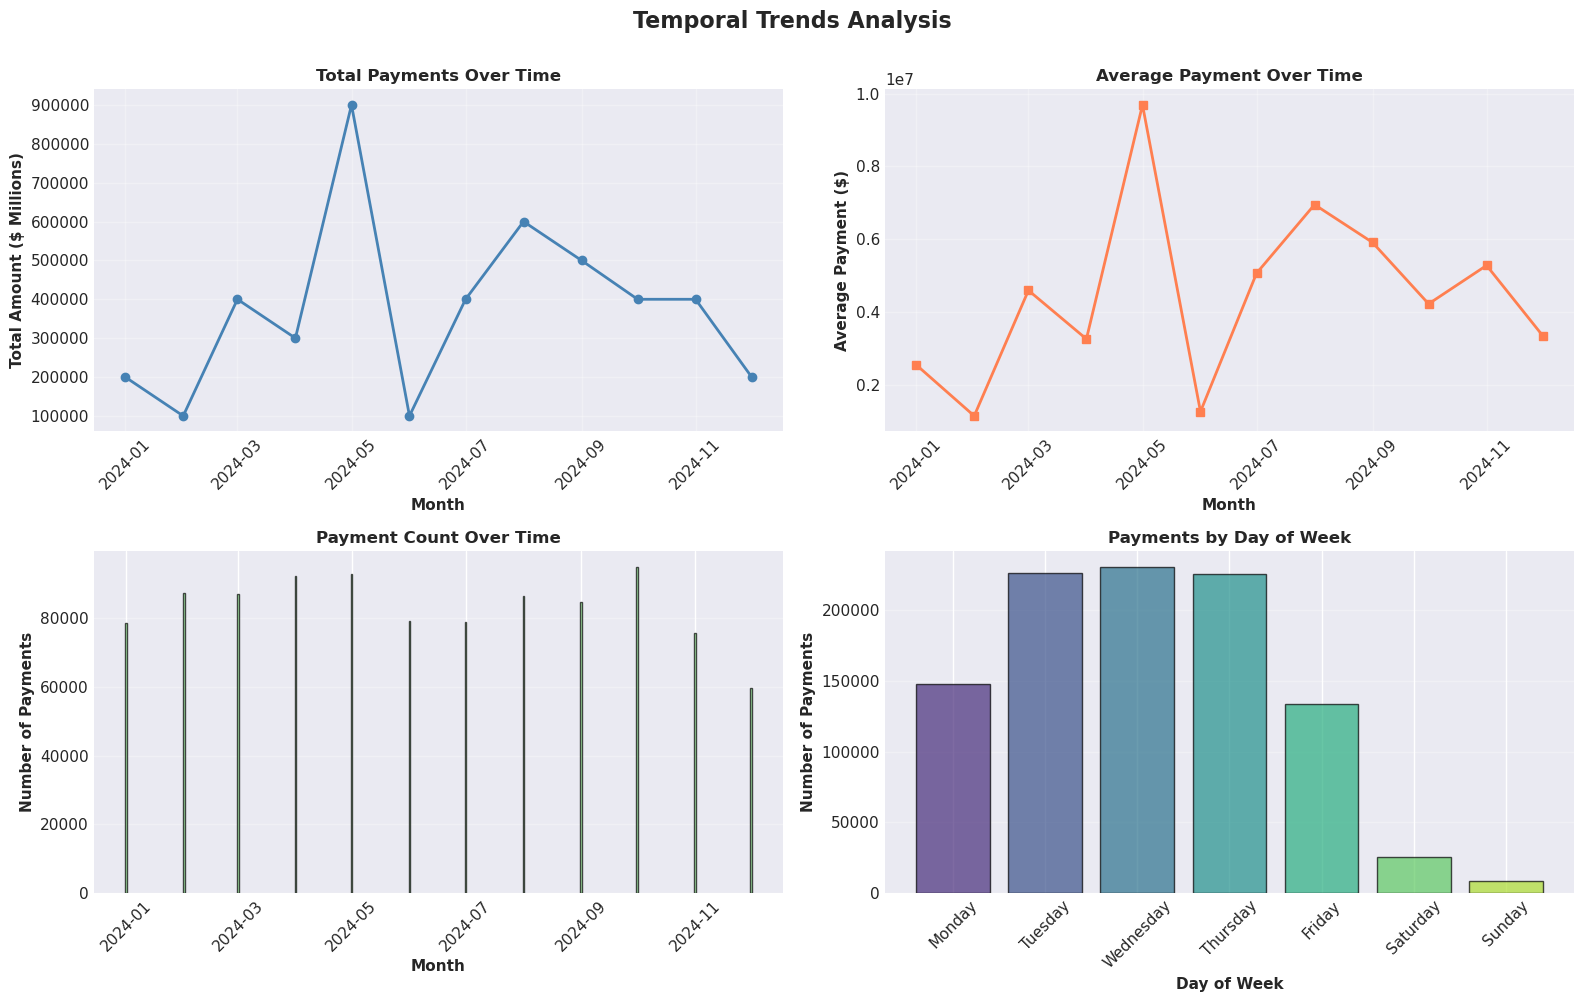

In [25]:
if 'date_of_payment' in df.columns and payment_col in df.columns:
    visualizer.plot_temporal_trends(df, date_col='date_of_payment', amount_col=payment_col)
    plt.show()

Quarterly Payment Statistics:


,Count,Total ($),Mean ($),Median ($)
Quarter,,,,
1,252997,700020663241.36,2766912.90,20.02
2,264233,1300023350254.92,4919988.61,20.02
3,249917,1500019838580.19,6002072.04,20.02
4,230215,1000025587857.92,4343876.76,20.02


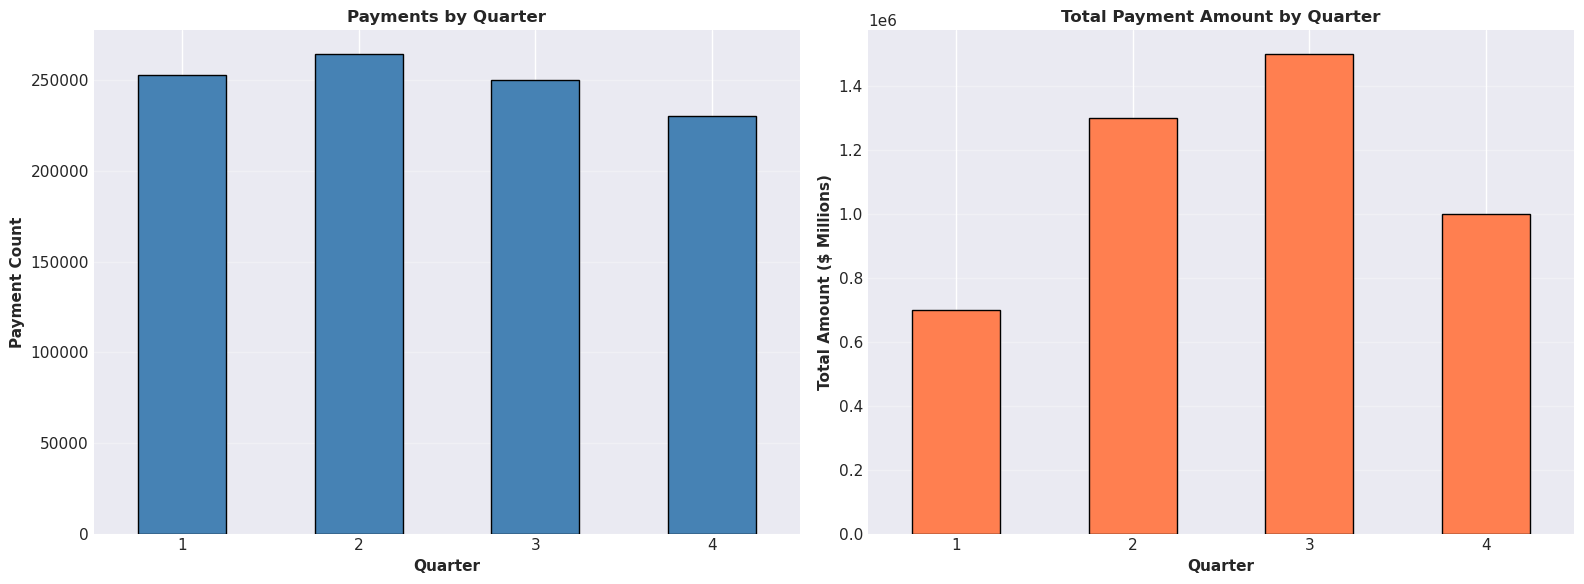

In [26]:
if 'payment_quarter' in df.columns and payment_col in df.columns:
    quarterly_stats = df.groupby('payment_quarter')[payment_col].agg(['count', 'sum', 'mean', 'median']).round(2)
    quarterly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    quarterly_stats.index.name = 'Quarter'
    
    print("Quarterly Payment Statistics:")
    display(quarterly_stats)
    
    visualizer.plot_quarterly_trends(df, quarter_col='payment_quarter', amount_col=payment_col)
    plt.show()

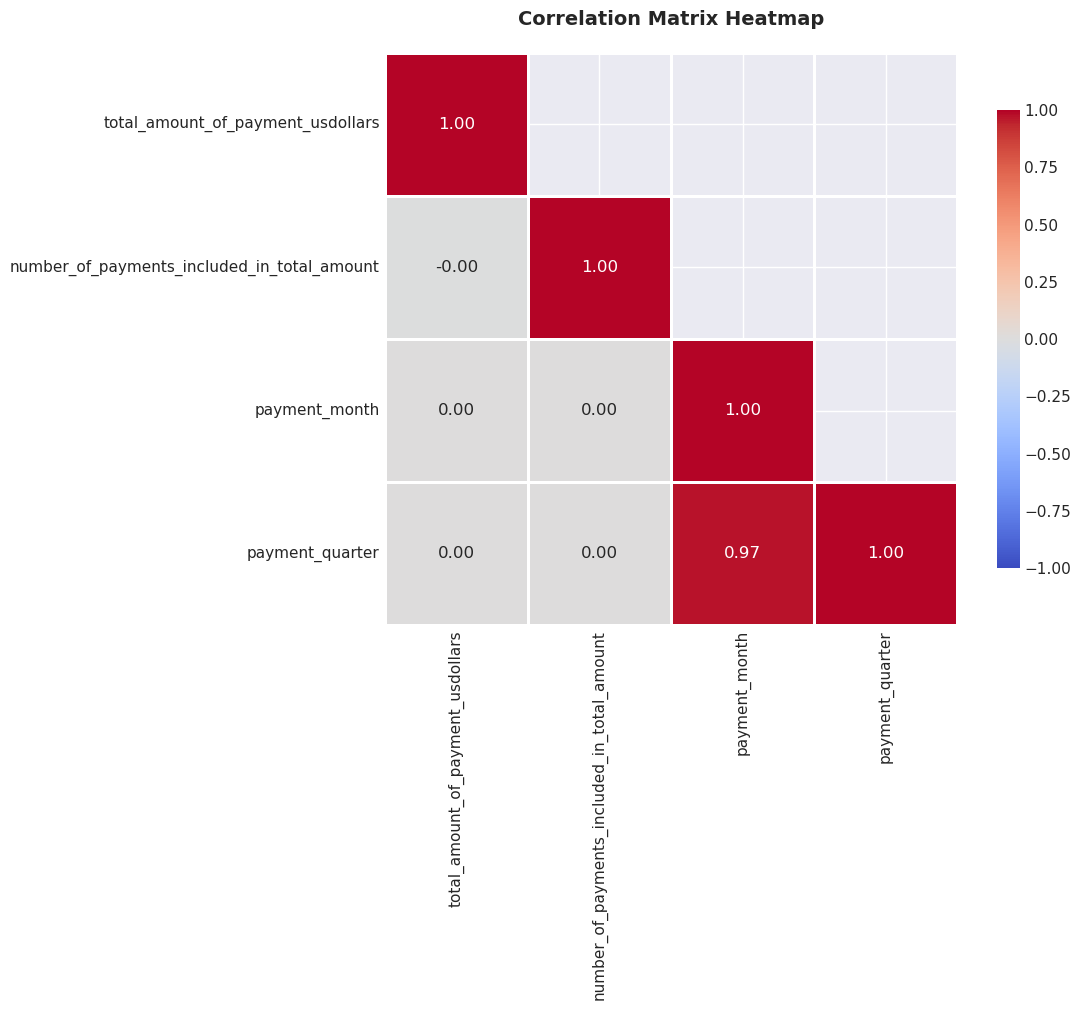

In [27]:
numeric_features_eda = [payment_col, 'number_of_payments_included_in_total_amount']
if 'payment_month' in df.columns:
    numeric_features_eda.append('payment_month')
if 'payment_quarter' in df.columns:
    numeric_features_eda.append('payment_quarter')

available_numeric = [col for col in numeric_features_eda if col in df.columns]

if len(available_numeric) >= 2:
    visualizer.plot_correlation_heatmap(df, available_numeric)
    plt.show()

### Interpretation of the Exploratory Data Analysis
- **Dataset**: 
    - There are about 1 million payments. Most payments are small, but a few are extremely large.
    - Because a few payments are huge, the average (mean) looks very high, but the typical payment (median) is only about $20.
    - The goal of anomaly detection here is to find those unusual payments but first the data needs cleaning so the model doesn’t just catch bad/dirty data.
    - The state column has values that are not states (like “3RD FLOOR” or “YALE UNIVERSITY”). This likely means data is messy or columns got mixed.
    - The nature of payment list also has wrong values (like “United States”, “NJ”, or numbers). This is another sign of dirty categories.

- **Payment Amount Distribution (normal)**:
    - The chart looks like almost everything is near zero.
    - That happens because a few very big payments stretch the scale and hide the small ones.

- **Payment Amount Distribution (log scale)**
    - This view makes the data easier to see. It shows most payments are in a normal range, and there’s a long tail of bigger payments that may be unusual.

- **Box plot (amount)**
    - Most payments are clustered very low.
    - There are many outliers (payments much larger than normal), including some extremely large ones.

- **Violin plot (amount)**
    - Thick at the bottom = most payments are small.
    - Thin long line upward = a small number of payments are very large.

- **Recipient type vs amount (box/violin)**
    - Doctors and non-doctors have similar typical payment sizes.
    - Both groups still have very large outliers, so recipient type alone doesn’t explain unusual payments.

- **Top 15 payment “nature” by total**
    - Some categories make sense (Food & Beverage, Consulting, Travel).
    - Some categories don’t make sense (United States, NJ, numbers), meaning the data needs cleanup before using it for modeling.

- **Monthly payment count + monthly total amount**
    - The number of payments changes a bit month to month.
    - The total dollars change a lot more, meaning a few big payments can make one month look huge, even if the number of payments is normal.

- **Temporal trends (total, average, count, weekday)**
    - Big spikes in total/average usually mean very large payments happened.
    - Most payments happen on weekdays; weekend payments are fewer, so a big weekend payment can be more “unusual.”

- **Payments by quarter + total by quarter**
    - Payment counts per quarter are fairly similar.
    - Total dollars per quarter vary more, again because of large payments.

- **Correlation heatmap**
    - Month and quarter are related (quarter is basically grouped months).
    - Amount is not strongly tied to month/quarter, so unusual payments are not just “because of season.”

## 6. Feature Engineering

This section creates model-ready variables by transforming raw payment fields into meaningful signals, such as logscaled amounts, time based features (month/quarter/day), and cleaned categorical indicators.

These engineered features capture patterns in payment size, frequency, category, and timing, helping anomaly models detect unusual behavior more reliably.

In [28]:
np.random.seed(42)
perms = np.random.rand(len(df))

df['dataset_usage'] = pd.cut(
    perms, 
    bins=[0, 0.4, 0.5, 0.6, 1.0], 
    labels=['train', 'test', 'validation', 'production']
)

split_summary = df['dataset_usage'].value_counts().sort_index()
print("Data Split (40/10/10/40):")
for label in split_summary.index:
    pct = split_summary[label] / len(df) * 100
    print(f"  {label.capitalize()}: {split_summary[label]:,} ({pct:.1f}%)")

Data Split (40/10/10/40):
  Train: 398,604 (40.0%)
  Test: 99,600 (10.0%)
  Validation: 99,705 (10.0%)
  Production: 399,453 (40.1%)


In [29]:
target_id = 'covered_recipient_profile_id' 
payment_col = 'total_amount_of_payment_usdollars'

df_train = df[df['dataset_usage'] == 'train']
global_median = df_train[payment_col].median()

recipient_features = df_train.groupby(target_id).agg({
    payment_col: ['count', 'sum', 'mean', 'std', 'max']
}).reset_index()

recipient_features.columns = [
    target_id, 'hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 'hist_pay_std', 'hist_pay_max'
]

df = df.merge(recipient_features, on=target_id, how='left')

df['amt_to_avg_ratio'] = df[payment_col] / df['hist_pay_avg']
df['amt_to_max_ratio'] = df[payment_col] / df['hist_pay_max']
df['is_new_recipient'] = df['hist_pay_avg'].isnull().astype(int)

df['hist_pay_avg'] = df['hist_pay_avg'].fillna(global_median)
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)
df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']] = \
    df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']].fillna(0)

print("Baseline features created")

Baseline features created


In [30]:
risk_categories = ['Gift', 'Entertainment', 'Travel and Lodging']
nature_col = 'nature_of_payment_or_transfer_of_value'

if nature_col in df.columns:
    df['is_high_risk_nature'] = df[nature_col].isin(risk_categories).astype(int)

print("Risk features created")

Risk features created


In [31]:
numeric_cols_df = df.select_dtypes(include=[np.number]).columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in numeric_cols_df:
    if col in df.columns:
        q999 = df[col].quantile(0.999)
        q001 = df[col].quantile(0.001)
        df[col] = df[col].clip(lower=q001, upper=q999)

print("Outliers capped")

Outliers capped


## 7. Isolation Forest Model Training

Isolation Forest is an anomaly detection method that finds unusual records by repeatedly splitting the data into random partitions. Points that get isolated in fewer splits (shorter paths) are considered more likely to be anomalies.

In [32]:
df_payments = df.copy()

numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_code', '_province', '_postal'])]

X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X = X.fillna(X.median())

print(f"Features prepared: {X.shape}")

Features prepared: (997362, 16)


In [33]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Train: 797,889 | Test: 199,473


In [34]:
baseline_params = {
    'n_estimators': 200,
    'contamination': 0.05,
    'max_samples': 'auto',
    'max_features': 1.0,
    'bootstrap': False,
    'random_state': 42
}

isolation_forest = IsolationForest(**baseline_params, n_jobs=-1, verbose=0)

print("Training Isolation Forest...")
start_time = time.time()
isolation_forest.fit(X_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f}s")

Training Isolation Forest...
Training completed in 11.04s


In [35]:
train_predictions = isolation_forest.predict(X_train)
train_scores = isolation_forest.decision_function(X_train)

test_predictions = isolation_forest.predict(X_test)
test_scores = isolation_forest.decision_function(X_test)

train_anomalies = (train_predictions == -1).astype(int)
test_anomalies = (test_predictions == -1).astype(int)

train_anomaly_count = train_anomalies.sum()
test_anomaly_count = test_anomalies.sum()

print(f"Train Anomalies: {train_anomaly_count:,} ({train_anomaly_count/len(X_train)*100:.2f}%)")
print(f"Test Anomalies: {test_anomaly_count:,} ({test_anomaly_count/len(X_test)*100:.2f}%)")

Train Anomalies: 39,895 (5.00%)
Test Anomalies: 9,857 (4.94%)


In [36]:
all_scores = isolation_forest.decision_function(X_scaled)
all_predictions = isolation_forest.predict(X_scaled)

anomaly_results = df_payments.copy()
anomaly_results['anomaly_score'] = all_scores
anomaly_results['is_anomaly'] = (all_predictions == -1).astype(int)
anomaly_results['anomaly_score_percentile'] = pd.Series(all_scores).rank(pct=True) * 100

anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('anomaly_score', ascending=True)
normal_df = anomaly_results[anomaly_results['is_anomaly'] == 0]

print(f"Total Anomalies: {len(anomalies_df):,} ({len(anomalies_df)/len(anomaly_results)*100:.2f}%)")

top_anomalies = model_viz.display_top_anomalies(anomalies_df=anomalies_df, score_col='anomaly_score', top_n=10)
display(top_anomalies)

Total Anomalies: 49,752 (4.99%)

=== Top 10 Anomalous Payments (n=49,752) ===


,anomaly_score,anomaly_score_percentile,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
259622,-0.10,0.00,6400.00,Covered Recipient Physician,"""Compensation for services other than consulting",174.83,24.49,0,1,0
960701,-0.10,0.00,3600.00,Covered Recipient Physician,"""Compensation for services other than consulting",84.54,42.58,0,1,0
526301,-0.10,0.00,1005.00,Covered Recipient Physician,Consulting Fee,31.72,31.68,0,0,0
839840,-0.10,0.00,5000.00,Covered Recipient Physician,Consulting Fee,86.44,57.85,0,0,0
396135,-0.10,0.00,3280.00,Covered Recipient Physician,"""Compensation for services other than consulting",32.14,102.06,0,0,0
979524,-0.10,0.00,3625.00,Covered Recipient Physician,"""Compensation for services other than consulting",14.34,252.86,0,0,0
95664,-0.10,0.00,1300.00,Covered Recipient Physician,"""Compensation for services other than consulting",19.86,65.47,0,0,0
182977,-0.09,0.00,7000.00,Covered Recipient Physician,Consulting Fee,42.08,166.36,0,0,0
441353,-0.09,0.00,506.03,Covered Recipient Physician,Travel and Lodging,17.00,29.77,0,1,1
856903,-0.09,0.00,733.17,Covered Recipient Physician,Travel and Lodging,28.57,25.67,0,1,1


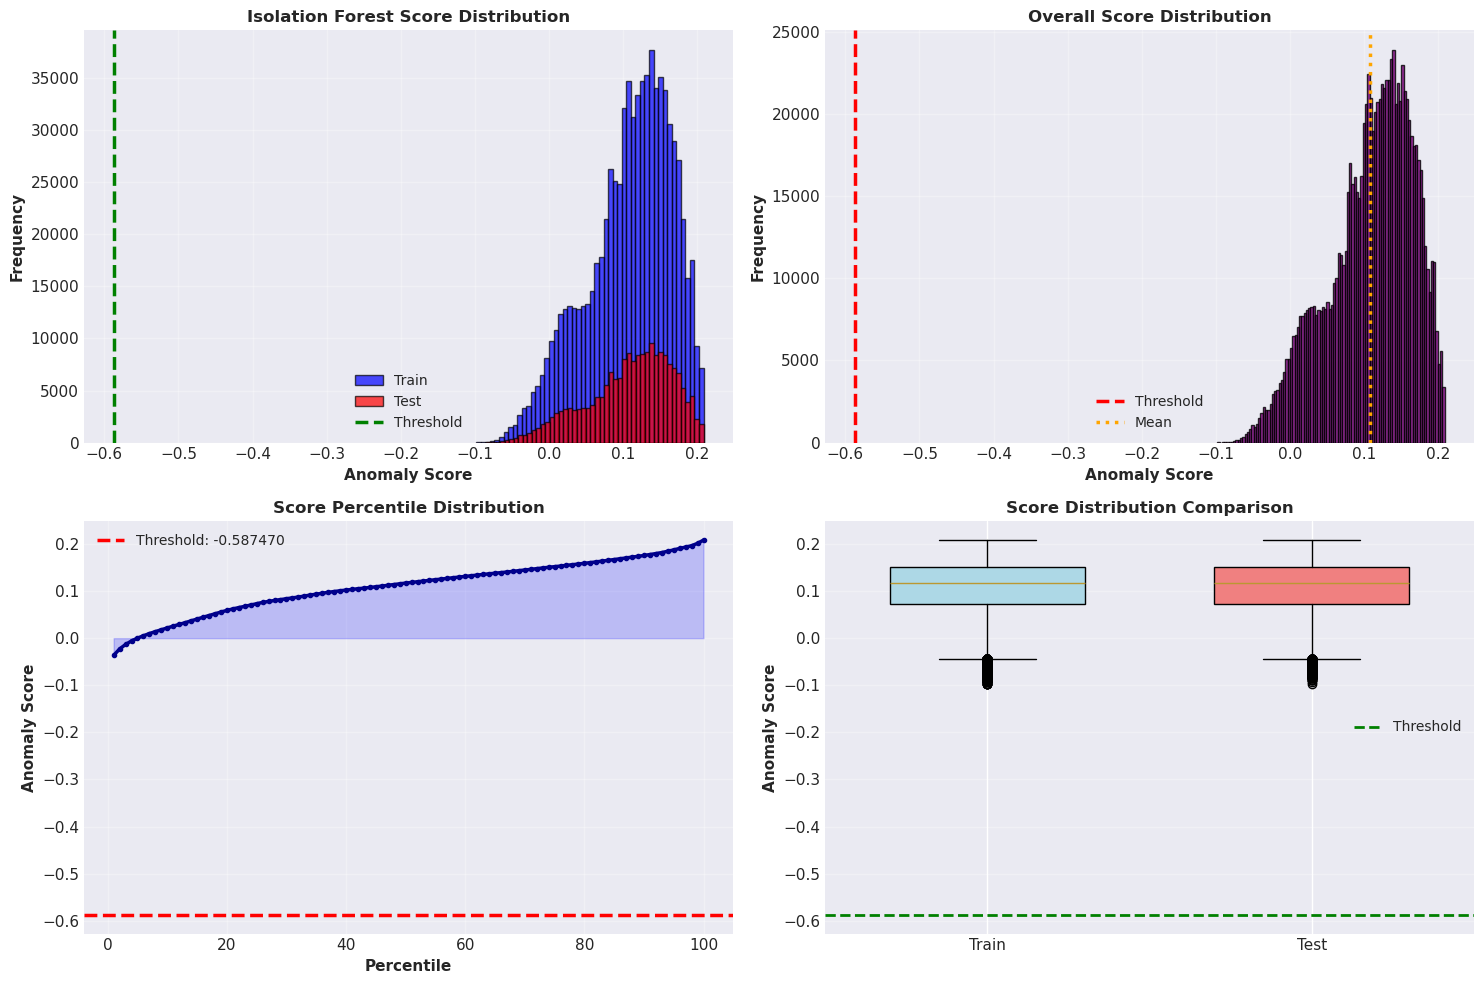

In [37]:
fig = model_viz.plot_anomaly_scores(
    train_scores=train_scores,
    test_scores=test_scores,
    threshold=isolation_forest.offset_,
    model_name='Isolation Forest'
)
plt.show()

### Anomaly Analysis by Payment Amount

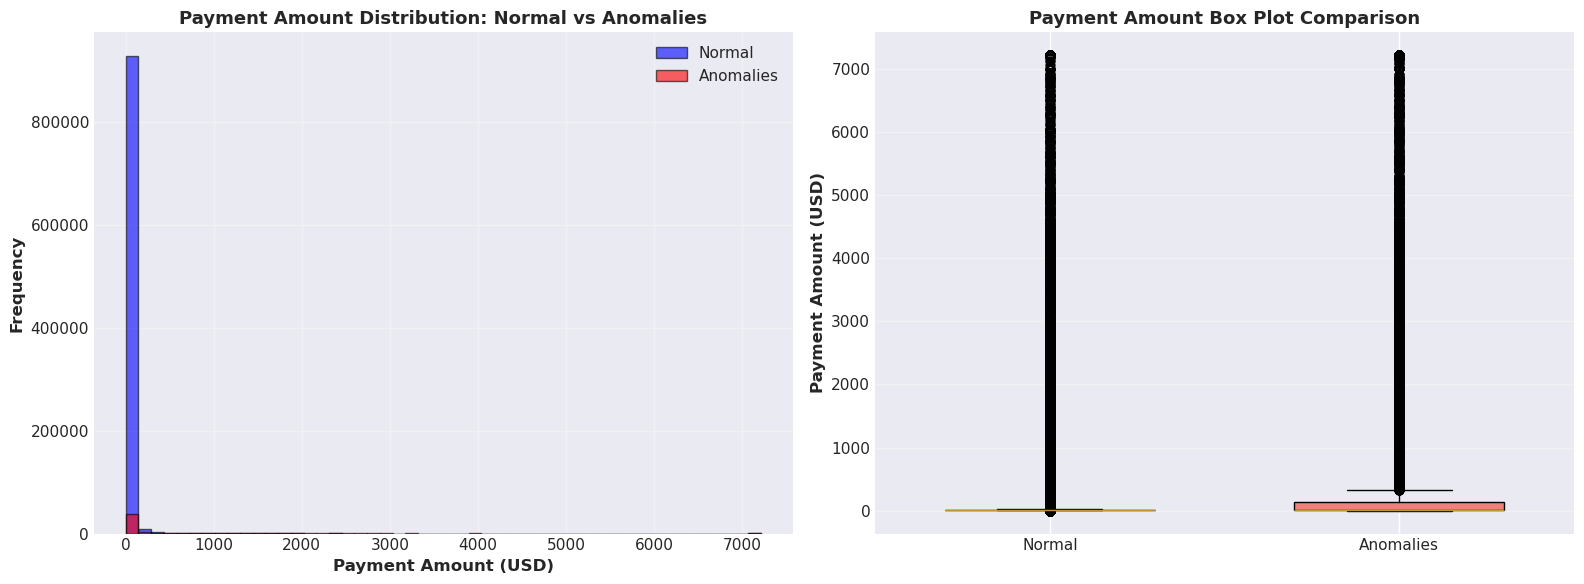

In [38]:
if 'total_amount_of_payment_usdollars' in anomaly_results.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df,
        anomaly_df=anomalies_df,
        amount_col='total_amount_of_payment_usdollars',
        score_col='anomaly_score'
    )
    plt.show()

### Training Performance Statistics

In [39]:
comparison_features = ['total_amount_of_payment_usdollars']
if 'amt_to_avg_ratio' in anomaly_results.columns:
    comparison_features.append('amt_to_avg_ratio')
if 'hist_pay_avg' in anomaly_results.columns:
    comparison_features.append('hist_pay_avg')

comparison_stats = model_viz.print_anomaly_stats(
    normal_df=normal_df,
    anomaly_df=anomalies_df,
    score_col='anomaly_score',
    comparison_features=comparison_features
)


=== Statistical Comparison ===
                                   Normal_Mean  Normal_Median  Anomaly_Mean  \
total_amount_of_payment_usdollars        43.58          20.02        466.01   
amt_to_avg_ratio                          1.52           1.00          4.49   
hist_pay_avg                             44.11          20.02        310.57   

                                   Anomaly_Median  Difference_%  
total_amount_of_payment_usdollars           20.02        969.39  
amt_to_avg_ratio                             0.63        194.99  
hist_pay_avg                                75.46        604.13  

=== Anomaly Score Statistics ===
   Metric  Normal  Anomaly
0    Mean    0.11    -0.02
1  Median    0.12    -0.02
2     Min    0.00    -0.10
3     Max    0.21    -0.00


In [40]:
train_anomaly_pct = (train_anomaly_count / len(X_train)) * 100
test_anomaly_pct = (test_anomaly_count / len(X_test)) * 100

print(f"Training Set: {train_anomaly_count:,} anomalies ({train_anomaly_pct:.2f}%)")
print(f"Test Set: {test_anomaly_count:,} anomalies ({test_anomaly_pct:.2f}%)")
print(f"Decision Threshold: {isolation_forest.offset_:.6f}")
print(f"Score Range: [{all_scores.min():.6f}, {all_scores.max():.6f}]")

Training Set: 39,895 anomalies (5.00%)
Test Set: 9,857 anomalies (4.94%)
Decision Threshold: -0.587470
Score Range: [-0.098304, 0.208233]


### Interpretation of Isolation Forest Results
- **What was done**: The dataset was turned into 16 model features (about 997k rows) and split into 80% train (797,889) and 20% test (199,473).
- **Training speed**: The model trained quickly (~11 seconds), which is a good sign for scaling and future retraining.
- **How many anomalies were found**: The model was configured to flag about 5% of records as unusual. It found 39,895 anomalies in train (5.00%) and 9,857 in test (4.94%) → very consistent, meaning the model is behaving similarly on new data.


1. **Isolation Forest Score Distribution (Train vs Test)**: The train and test score shapes look similar. It means the model isn’t “overreacting” differently on test data.
1. **Overall Score Distribution (with mean + threshold line)**: Most payments sit in the “normal” score region near the mean. The left side (more negative scores) contains the unusual payments.
1. **Score Percentile Distribution**: Scores become more “anomalous” (lower) as you move to the lowest percentiles. This helps pick a cutoff such as “flag the bottom 5%”.
1. **Train vs Test Box Plot (Score Distribution Comparison)**: Both train and test have similar medians and spreads. This shows the model is stable and generalizes.
1. **Payment Amount Distribution: Normal vs Anomalies**: Normal payments are heavily concentrated at small amounts. Anomalies include more payments in the higher amount range, so the model is using payment size as a strong signal.
1. **Payment Amount Box Plot: Normal vs Anomalies**: The anomaly group has a much wider range and higher values. This confirms anomalies are not random—they are different in magnitude/behavior.

### Conclusion
- The model trained fast, produced a consistent ~5% anomaly rate on both train and test, and is mainly flagging payments that are unusually high or unusual relative to historical/context averages.
- Before treating these as “fraud/suspicious,” the big next step is validating that anomalies aren’t caused by dirty categories (state/nature issues seen in EDA) and ensuring the threshold logic matches the score scale.

## 8. Autoencoder Model Training

Autoencoders are neural networks that learn to compress data into a smaller representation and then reconstruct it back to the original. Records that reconstruct poorly (high reconstruction error) are treated as anomalies because they don’t follow the normal patterns the model learned.

In [41]:
X_ae = df_payments[numeric_features].copy().astype(float)
X_ae = X_ae.replace([np.inf, -np.inf], np.nan)

missing_pct_ae = (X_ae.isnull().sum() / len(X_ae)) * 100
cols_to_keep_ae = missing_pct_ae[missing_pct_ae <= 50].index.tolist()
X_ae = X_ae[cols_to_keep_ae]

for col in X_ae.columns:
    q1, q3 = X_ae[col].quantile(0.25), X_ae[col].quantile(0.75)
    iqr = q3 - q1
    X_ae[col] = X_ae[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X_ae = X_ae.fillna(X_ae.median())

scaler_ae = MinMaxScaler(feature_range=(0, 1))
X_ae_scaled = scaler_ae.fit_transform(X_ae)
X_ae_scaled = pd.DataFrame(X_ae_scaled, columns=X_ae.columns)

X_ae_train, X_ae_test = train_test_split(X_ae_scaled, test_size=0.2, random_state=42)

print(f"Data prepared: {X_ae_scaled.shape} | Train: {len(X_ae_train):,} | Test: {len(X_ae_test):,}")

Data prepared: (997362, 16) | Train: 797,889 | Test: 199,473


In [42]:
input_dim = X_ae_scaled.shape[1]
encoding_dim_1 = max(input_dim // 2, 32)
encoding_dim_2 = max(input_dim // 4, 16)
bottleneck_dim = max(input_dim // 8, 8)

autoencoder = Sequential([
    layers.Dense(encoding_dim_1, activation='relu', input_shape=(input_dim,), name='encoder_input'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_2, activation='relu', name='encoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(bottleneck_dim, activation='relu', name='bottleneck'),
    layers.Dense(encoding_dim_2, activation='relu', name='decoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_1, activation='relu', name='decoder_layer'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='sigmoid', name='decoder_output')
], name='Autoencoder')

optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print(f"Architecture: {input_dim} -> {encoding_dim_1} -> {encoding_dim_2} -> {bottleneck_dim} (bottleneck)")

Architecture: 16 -> 32 -> 16 -> 8 (bottleneck)


In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=0,
    min_delta=1e-5
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

start_time = time.time()

history_ae = autoencoder.fit(
    X_ae_train, X_ae_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

training_time_ae = time.time() - start_time
print(f"Training: {len(history_ae.history['loss'])} epochs in {training_time_ae:.2f}s")

Training: 50 epochs in 1176.81s


In [44]:
train_predictions_ae = autoencoder.predict(X_ae_train, verbose=0)
train_mse_ae = np.mean(np.square(X_ae_train - train_predictions_ae), axis=1)

test_predictions_ae = autoencoder.predict(X_ae_test, verbose=0)
test_mse_ae = np.mean(np.square(X_ae_test - test_predictions_ae), axis=1)

all_data_ae = np.vstack([X_ae_train, X_ae_test])
all_predictions_ae = autoencoder.predict(all_data_ae, verbose=0)
all_reconstruction_errors = np.mean(np.square(all_data_ae - all_predictions_ae), axis=1)

threshold_ae = np.percentile(train_mse_ae, 95)
anomaly_labels_ae = (all_reconstruction_errors > threshold_ae).astype(int)
anomaly_count_ae = anomaly_labels_ae.sum()

print(f"Threshold: {threshold_ae:.6f} | Anomalies: {anomaly_count_ae:,} ({anomaly_count_ae/len(anomaly_labels_ae)*100:.2f}%)")

Threshold: 0.019398 | Anomalies: 49,843 (5.00%)


In [45]:
all_predictions_ae_full = autoencoder.predict(X_ae_scaled, verbose=0)
all_reconstruction_errors_full = np.mean(np.square(X_ae_scaled - all_predictions_ae_full), axis=1)
anomaly_labels_ae_full = (all_reconstruction_errors_full > threshold_ae).astype(int)

anomaly_results_ae = df_payments.copy()
anomaly_results_ae['reconstruction_error'] = all_reconstruction_errors_full
anomaly_results_ae['is_anomaly'] = anomaly_labels_ae_full

anomalies_df_ae = anomaly_results_ae[anomaly_results_ae['is_anomaly'] == 1].copy()
anomalies_df_ae = anomalies_df_ae.sort_values('reconstruction_error', ascending=False)
normal_df_ae = anomaly_results_ae[anomaly_results_ae['is_anomaly'] == 0]

top_anomalies_ae = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df_ae,
    score_col='reconstruction_error',
    top_n=10
)
display(top_anomalies_ae)


=== Top 10 Anomalous Payments (n=49,843) ===


,reconstruction_error,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
764829,0.11,20.02,Covered Recipient Non-Physician Practitioner,1,6.90,2.90,0,1,0
315885,0.11,20.02,Covered Recipient Non-Physician Practitioner,1,2.18,9.20,0,1,0
947812,0.11,20.02,Covered Recipient Physician,1,2.09,9.56,0,1,0
491575,0.11,20.02,Covered Recipient Non-Physician Practitioner,1,2.04,9.80,0,0,0
304550,0.11,20.02,Covered Recipient Physician,1,2.16,9.29,0,1,0
636453,0.11,20.02,Covered Recipient Physician,1,2.12,9.44,0,0,0
249158,0.11,25.44,Covered Recipient Non-Physician Practitioner,Food and Beverage,1.50,17.00,0,0,0
204850,0.10,26.18,Covered Recipient Non-Physician Practitioner,Food and Beverage,1.30,20.14,0,1,0
654836,0.10,20.02,Covered Recipient Physician,1,2.19,9.15,0,0,0
890947,0.10,20.02,Covered Recipient Physician,1,2.96,6.77,0,0,0


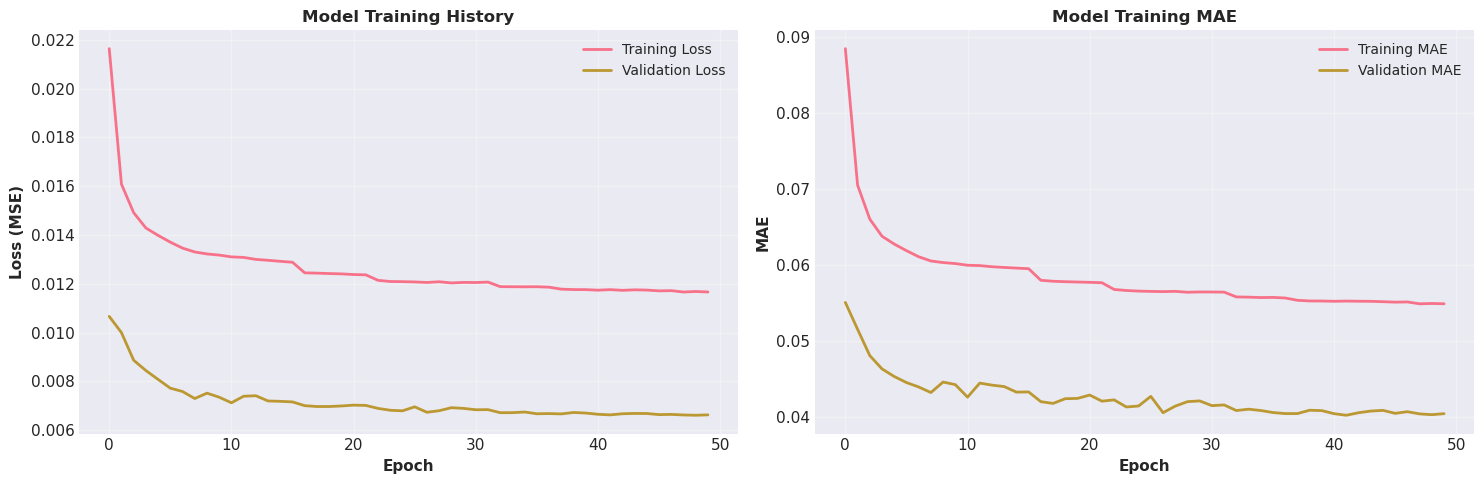

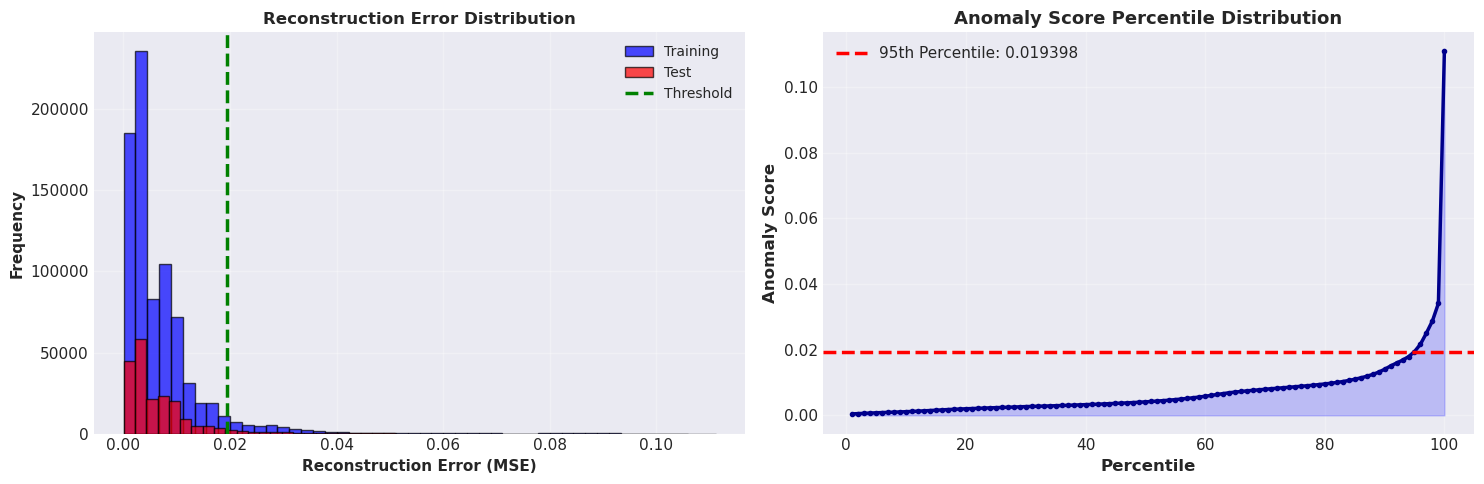

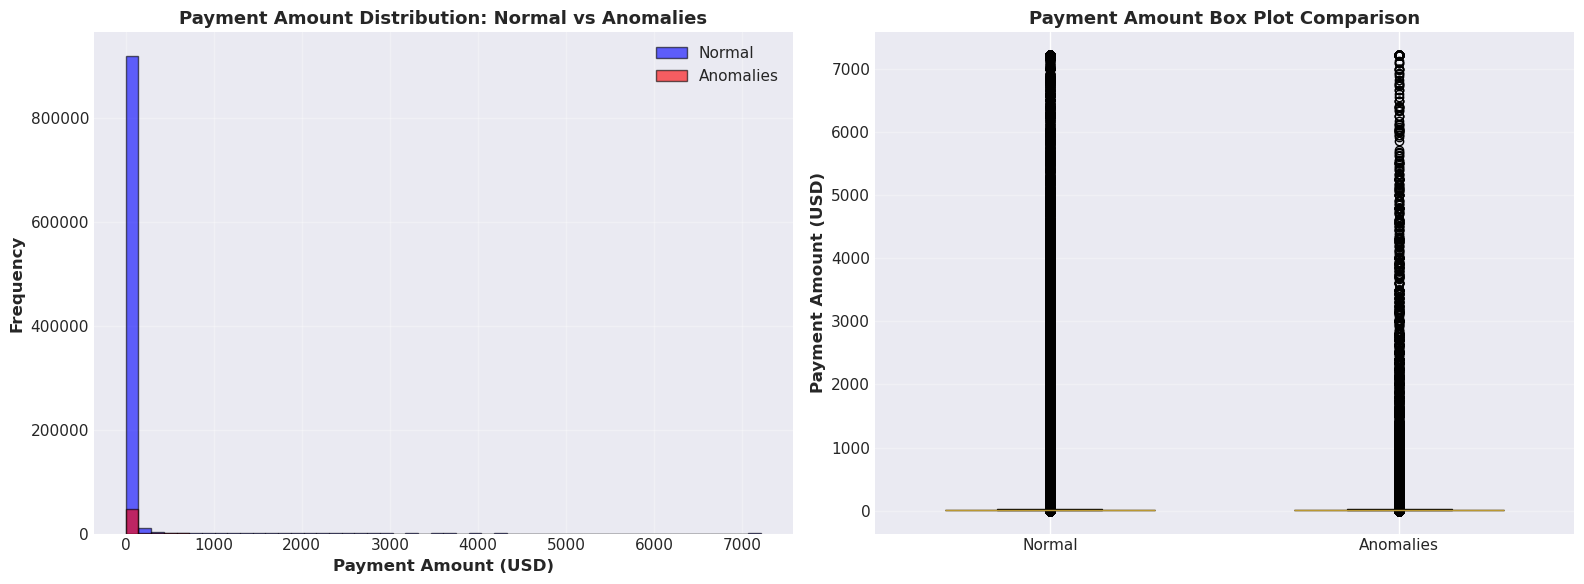

In [46]:
fig = model_viz.plot_training_history(history=history_ae.history, figsize=(15, 5))
plt.show()

fig = model_viz.plot_reconstruction_error_analysis(
    train_mse=train_mse_ae,
    test_mse=test_mse_ae,
    threshold=threshold_ae,
    all_reconstruction_errors=all_reconstruction_errors,
    figsize=(15, 5)
)
plt.show()

if 'total_amount_of_payment_usdollars' in anomaly_results_ae.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df_ae,
        anomaly_df=anomalies_df_ae,
        amount_col='total_amount_of_payment_usdollars',
        score_col='reconstruction_error'
    )
    plt.show()

### Interpretation of Autoencoder Results
- **What was done**: 
    - The same prepared dataset was used: 997,362 rows × 16 features, split into 80% train (797,889) and 20% test (199,473).
    - The autoencoder learned what “normal” payments look like and then tried to rebuild (reconstruct) each record.
    - If it rebuilds a record poorly (high reconstruction error), that record is treated as an anomaly.
- **Architecture**: A simple feedforward autoencoder with hidden layers 16 → 32 → 16 → 8 (bottleneck) was used to capture complex relationships in the data. It starts with 16 input features, expands to 32 to learn patterns, compresses down to 8 and then reconstructs back to 16. The 8 node bottleneck forces the model to learn a compressed representation of normal payments, making it easier to identify anomalies that don’t fit those patterns.

- **Training performance**: The model trained for 50 epochs with early stopping based on validation loss. The training and validation loss curves show the model learned to reconstruct normal payments while avoiding overfitting.

- **Training Loss vs Validation Loss (MSE)**: Both lines drop quickly early and then flatten out. This means the model learned the main pattern of the data and then improvements became small. Validation stays stable → no clear sign of severe overfitting.

- **Training MAE vs Validation MAE**: Error decreases and stabilizes. Indicates the model is consistently learning patterns that also apply to unseen data. Training looks stable, and the model converged normally.

- **Reconstruction Error Distribution (Train vs Test)**: Most records have very low error and model reconstructs them well. A small tail extends to higher errors.The hard-to-reconstruct records are unusual.

- **Percentile curve + threshold**: Threshold was set at the 95th percentile: 0.019398. That means the model flags the top 5% highest reconstruction error as anomalies.

### Conclusion
- The autoencoder trained correctly and flags the top 5% most unusual patterns using reconstruction error.
- It appears to detect “weird combinations” of features, not just large payments—useful, but it also increases the chance it is catching data quality or encoding issues.
- Best next step is to review the top anomalies and confirm they are true unusual payments (not bad categories like `nature_of_payment = 1` or parsing artifacts).


## 9. XGBoost Model Training

XGBoost is a gradient-boosted decision tree algorithm that builds many small trees in sequence, where each new tree focuses on correcting the previous errors. It produces strong predictions (classification or regression) by combining these trees into one powerful model.

In [47]:
X_xgb = df_payments[numeric_features].copy().astype(float)
X_xgb = X_xgb.replace([np.inf, -np.inf], np.nan)

missing_pct_xgb = (X_xgb.isnull().sum() / len(X_xgb)) * 100
cols_to_keep_xgb = missing_pct_xgb[missing_pct_xgb <= 50].index.tolist()
X_xgb = X_xgb[cols_to_keep_xgb]

for col in X_xgb.columns:
    q1, q3 = X_xgb[col].quantile(0.25), X_xgb[col].quantile(0.75)
    iqr = q3 - q1
    X_xgb[col] = X_xgb[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X_xgb = X_xgb.fillna(X_xgb.median())

outlier_indicators = []
for col in X_xgb.columns:
    z_scores = np.abs((X_xgb[col] - X_xgb[col].mean()) / X_xgb[col].std())
    outlier_indicators.append((z_scores > 3).astype(int))

outlier_score = pd.DataFrame(outlier_indicators).T.sum(axis=1)
threshold_value = np.percentile(outlier_score, 95)
y_pseudo = (outlier_score >= threshold_value).astype(int)

print(f"Pseudo-labels: {y_pseudo.sum():,} anomalies ({y_pseudo.sum()/len(y_pseudo)*100:.2f}%)")

Pseudo-labels: 84,850 anomalies (8.51%)


In [48]:
scaler_xgb = RobustScaler()
X_xgb_scaled = scaler_xgb.fit_transform(X_xgb)
X_xgb_scaled = pd.DataFrame(X_xgb_scaled, columns=X_xgb.columns)

X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(
    X_xgb_scaled, y_pseudo, 
    test_size=0.2, 
    random_state=42,
    stratify=y_pseudo
)

print(f"Train: {len(X_xgb_train):,} ({y_xgb_train.sum()} anomalies) | Test: {len(X_xgb_test):,} ({y_xgb_test.sum()} anomalies)")

Train: 797,889 (67880 anomalies) | Test: 199,473 (16970 anomalies)


In [49]:
scale_pos_weight = (y_xgb_train == 0).sum() / (y_xgb_train == 1).sum()

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = time.time()
xgb_model.fit(
    X_xgb_train, y_xgb_train,
    eval_set=[(X_xgb_train, y_xgb_train), (X_xgb_test, y_xgb_test)],
    verbose=False
)
training_time_xgb = time.time() - start_time

print(f"Training: {training_time_xgb:.2f}s")

Training: 24.82s


AUC: Train=0.999998 | Test=0.999993


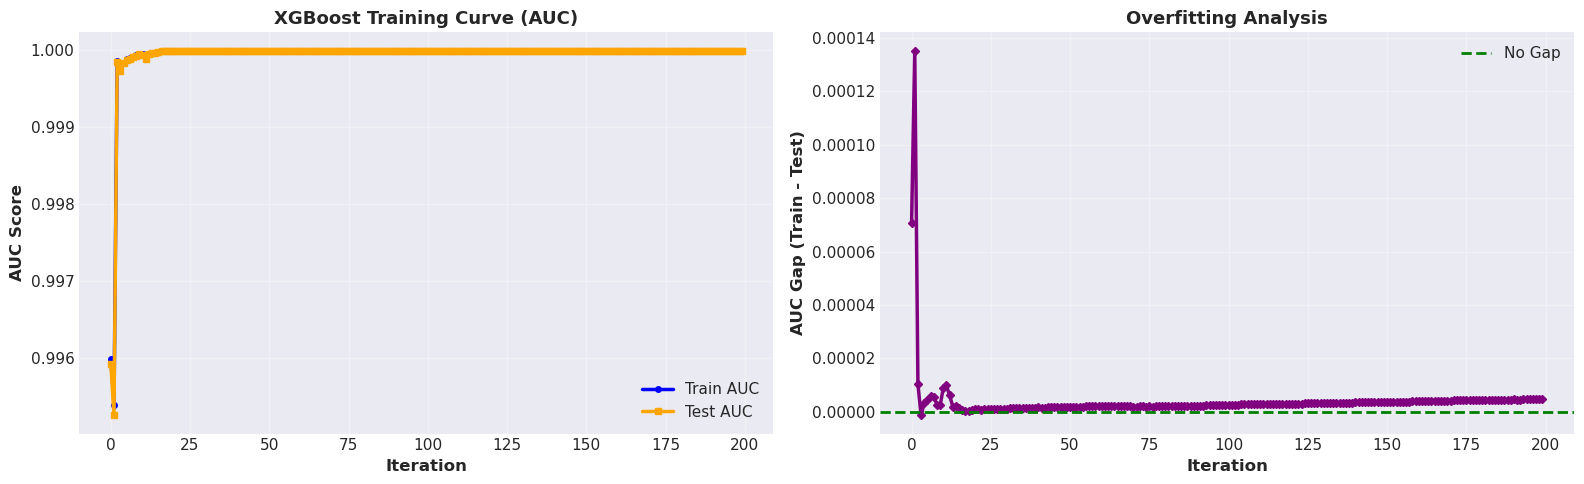

In [50]:
train_pred_xgb = xgb_model.predict(X_xgb_train)
train_proba_xgb = xgb_model.predict_proba(X_xgb_train)[:, 1]

test_pred_xgb = xgb_model.predict(X_xgb_test)
test_proba_xgb = xgb_model.predict_proba(X_xgb_test)[:, 1]

train_auc = roc_auc_score(y_xgb_train, train_proba_xgb)
test_auc = roc_auc_score(y_xgb_test, test_proba_xgb)

print(f"AUC: Train={train_auc:.6f} | Test={test_auc:.6f}")

results_xgb = xgb_model.evals_result()
best_iter = None
try:
    best_iter = xgb_model.best_iteration
except AttributeError:
    pass

fig = model_viz.plot_xgboost_training_curves(results=results_xgb, best_iteration=best_iter)
plt.show()

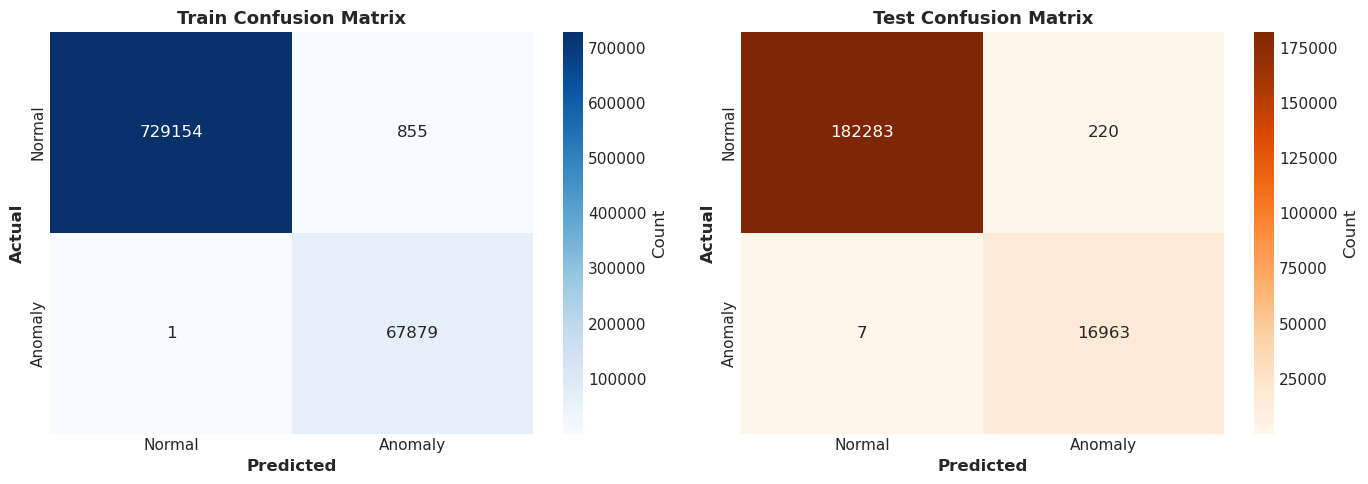

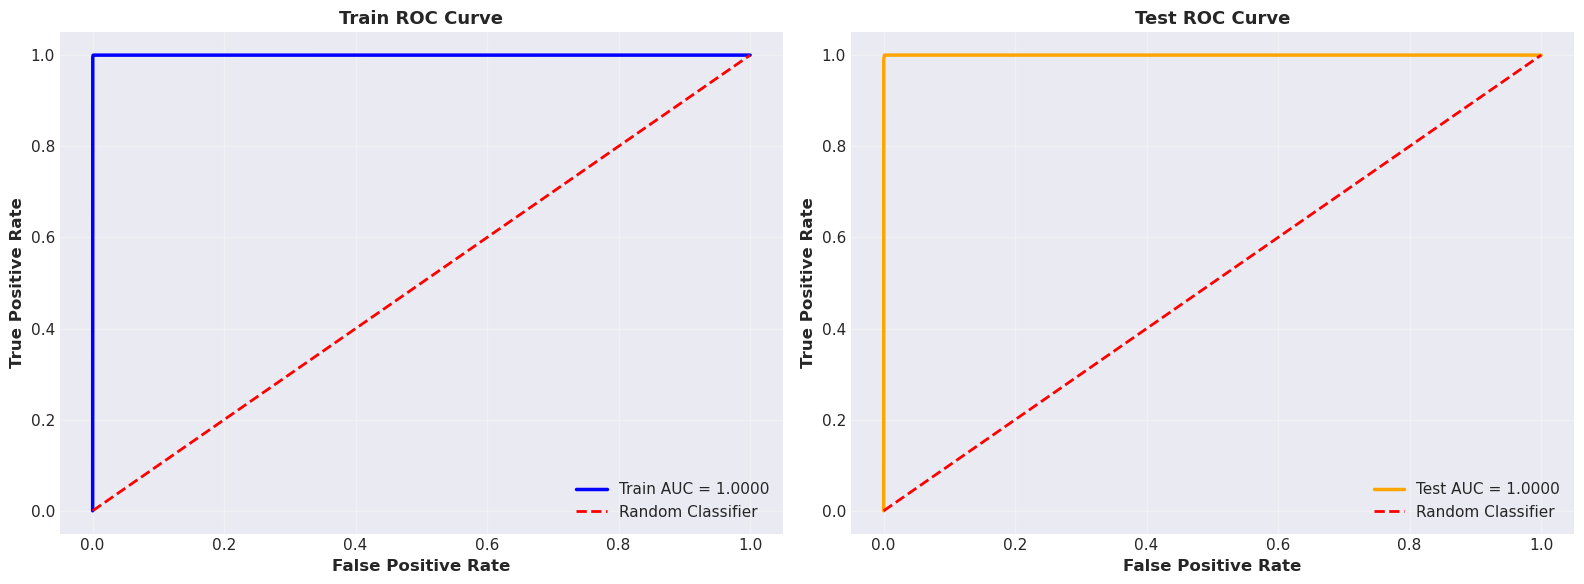

In [51]:
fig = model_viz.plot_confusion_matrices(
    y_train=y_xgb_train,
    train_pred=train_pred_xgb,
    y_test=y_xgb_test,
    test_pred=test_pred_xgb
)
plt.show()

fig = model_viz.plot_roc_curves(
    y_train=y_xgb_train,
    train_proba=train_proba_xgb,
    y_test=y_xgb_test,
    test_proba=test_proba_xgb,
    train_auc=train_auc,
    test_auc=test_auc
)
plt.show()

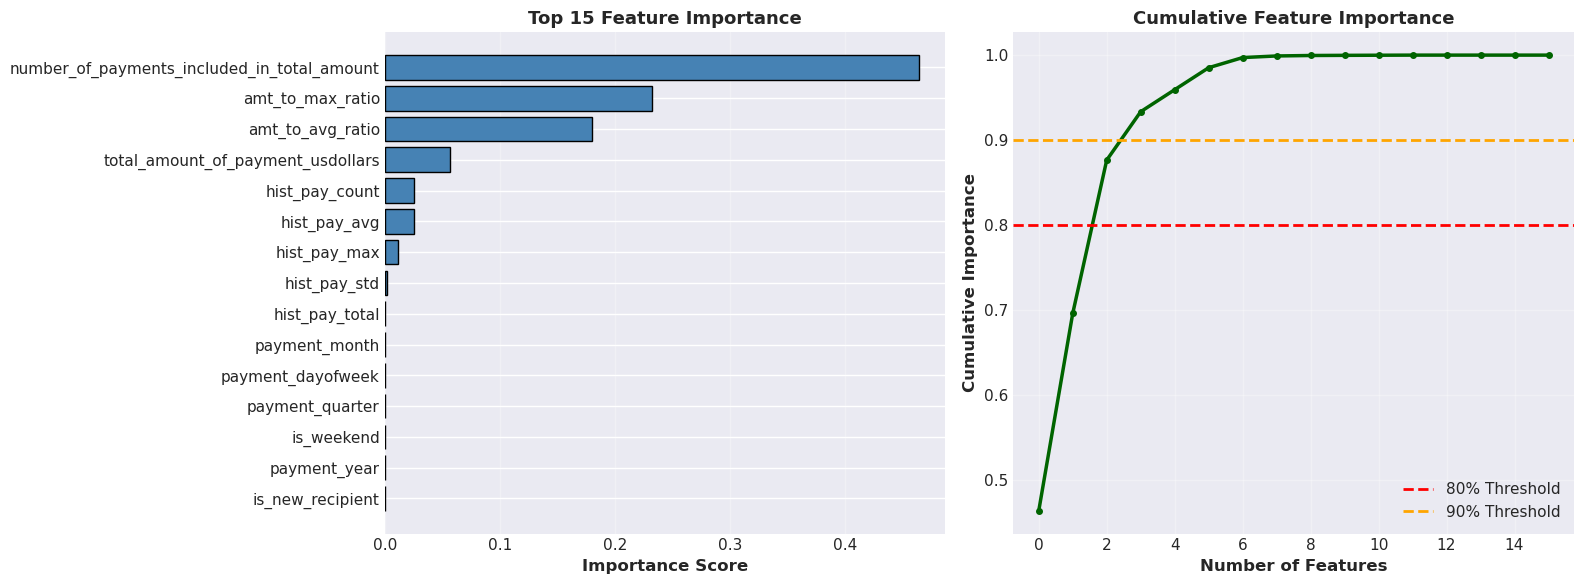

Top 10 Important Features:


,feature,importance
1,number_of_payments_included_in_total_amount,0.46
13,amt_to_max_ratio,0.23
12,amt_to_avg_ratio,0.18
0,total_amount_of_payment_usdollars,0.06
7,hist_pay_count,0.03
9,hist_pay_avg,0.03
11,hist_pay_max,0.01
10,hist_pay_std,0.00
8,hist_pay_total,0.00
3,payment_month,0.00


In [52]:
fig, feature_importance = model_viz.plot_feature_importance(
    feature_names=X_xgb.columns,
    feature_importances=xgb_model.feature_importances_,
    top_n=15
)
plt.show()

print("Top 10 Important Features:")
display(feature_importance.head(10))

Anomalies: 85,917 (8.61%)

=== Top 10 Anomalous Payments (n=85,917) ===


,anomaly_score,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
700952,1.00,20.02,Covered Recipient Physician,1,3.92,5.11,0,0,0
460549,1.00,20.02,Covered Recipient Physician,1,3.63,5.52,0,0,0
772418,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,6.36,3.15,0,0,0
433884,1.00,20.02,Covered Recipient Physician,1,3.60,5.56,0,0,0
463375,1.00,20.02,Covered Recipient Physician,1,4.38,4.57,0,0,0
141990,1.00,20.02,Covered Recipient Physician,1,12.49,1.64,0,0,0
382945,1.00,20.02,Covered Recipient Physician,1,3.39,5.91,0,0,0
133761,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,4.74,4.22,0,0,0
859530,1.00,20.02,Covered Recipient Physician,1,3.56,5.62,0,0,0
744798,1.00,20.02,Covered Recipient Physician,1,8.78,2.28,0,0,0


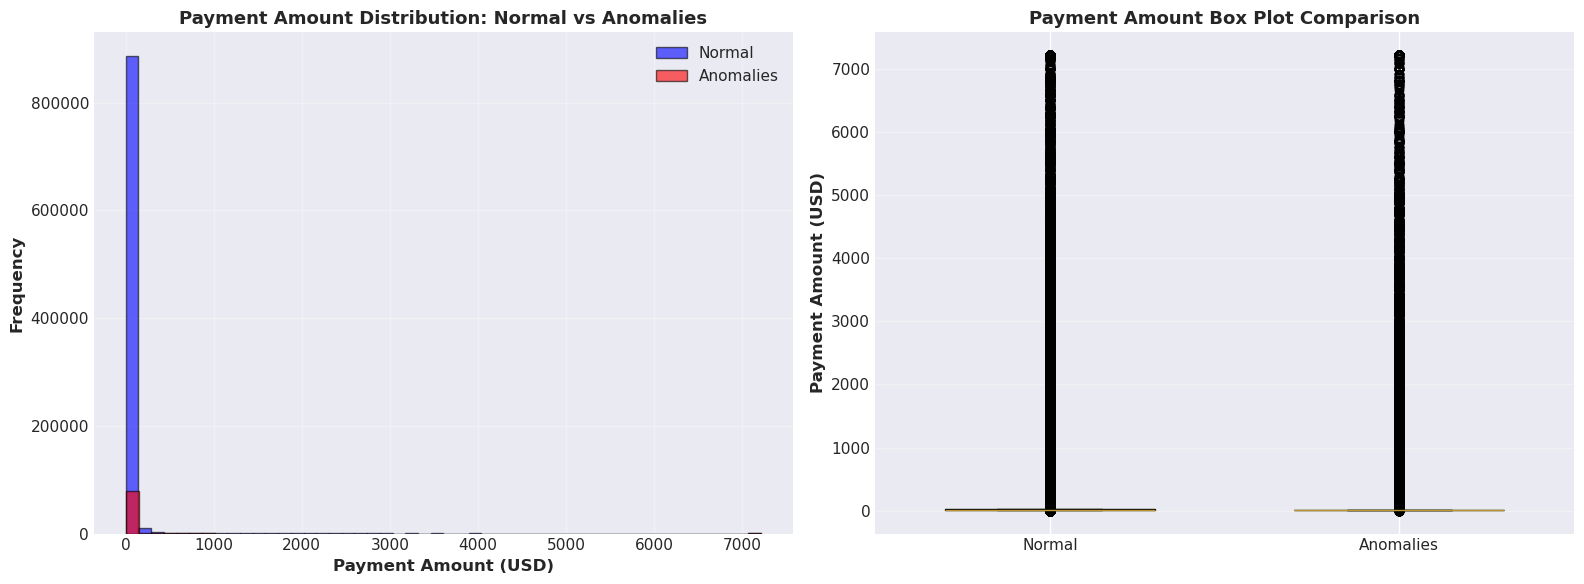

In [53]:
all_proba_xgb_full = xgb_model.predict_proba(X_xgb_scaled)[:, 1]

threshold_xgb = 0.5
anomaly_labels_xgb_full = (all_proba_xgb_full >= threshold_xgb).astype(int)

anomaly_results_xgb = df_payments.copy()
anomaly_results_xgb['anomaly_score'] = all_proba_xgb_full
anomaly_results_xgb['is_anomaly'] = anomaly_labels_xgb_full

anomalies_df_xgb = anomaly_results_xgb[anomaly_results_xgb['is_anomaly'] == 1].copy()
anomalies_df_xgb = anomalies_df_xgb.sort_values('anomaly_score', ascending=False)
normal_df_xgb = anomaly_results_xgb[anomaly_results_xgb['is_anomaly'] == 0]

print(f"Anomalies: {len(anomalies_df_xgb):,} ({len(anomalies_df_xgb)/len(anomaly_results_xgb)*100:.2f}%)")

top_anomalies_xgb = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df_xgb,
    score_col='anomaly_score',
    top_n=10
)
display(top_anomalies_xgb)

if 'total_amount_of_payment_usdollars' in anomaly_results_xgb.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df_xgb,
        anomaly_df=anomalies_df_xgb,
        amount_col='total_amount_of_payment_usdollars',
        score_col='anomaly_score'
    )
    plt.show()

### Interpretation of XGBoost Results
- XGBoost is a supervised classifier, so it needs labels. Since the dataset doesn’t have true “fraud/anomaly” labels, the notebook created pseudo-labels (marked ~8.5% rows as anomalies) using earlier rules/models. Then XGBoost learned patterns in the 16 features to predict those pseudo-anomaly labels.
- Training: 
    - Data: 997,362 rows × 16 features, split into 80% train (797,889) and 20% test (199,473).
    - Pseudo-labels: ~84,850 anomalies (8.51%). Training time: ~25 seconds (fast)
    - AUC: Train 0.999998 | Test 0.999993 (almost perfect separation)
- The model can almost perfectly reproduce the pseudo-labels on new data.

1. **AUC training curve**: Train and test AUC go to ~1.0 very quickly. This means the pseudo-labels are very easy to predict from the features.
1. **Overfitting analysis (AUC gap)**: The gap between train and test stays near zero. So it’s not classic overfitting; the model generalizes well to the same kind of labels.
1. **Confusion matrices (train + test)**: Shows the model matches the pseudo-labels extremely well.
1. **ROC curves (train + test)**: Curves hug the top-left corner and AUC is ~1.0. This confirms extremely strong separation—again, against pseudo-labels.
1. **Feature importance**:
    - `number_of_payments_included_in_total_amount` (0.46) shows biggest signal for anomalies is how many payments are included in the total amount. A single large payment may be more unusual than many small payments.
    - `amt_to_max_ratio` (0.23) and `amt_to_avg_ratio` (0.18) shows how unusual the amount is compared to a baseline
    - `total_amount_of_payment_usdollars` (0.06) shows raw amount matters but less than “ratio” features
### Conclusion
- XGBoost trained fast, generalizes well, and is highly consistent—but it is mainly learning the rules/patterns used to create pseudo-labels.
- The most important next step is to validate the pseudo-labels and clean categorical fields (especially the `nature_of_payment` encoding). Otherwise, XGBoost becomes a “data quality detector” rather than a “risk/anomaly detector.”


## 10. Hyperparameter Tuning

In [54]:
# Split data into train and validation for hyperparameter tuning
X_train_hp, X_val_hp = train_test_split(X_train, test_size=0.25, random_state=42)

print(f"Hyperparameter Tuning Split:")
print(f"Train: {len(X_train_hp):,} | Validation: {len(X_val_hp):,}")

def evaluate_isolation_forest(params, X_train_data, X_val_data):
    """
    Train and evaluate Isolation Forest with given parameters.
    Returns a robust separation score based on anomaly score distributions.
    """
    try:
        model = IsolationForest(**params, random_state=42, n_jobs=-1, verbose=0)
        model.fit(X_train_data)
        
        # Get scores on validation set
        val_scores = model.decision_function(X_val_data)
        val_predictions = model.predict(X_val_data)
        
        # Check for valid predictions
        if not np.isfinite(val_scores).all():
            return -np.inf
        
        # Separate anomaly and normal scores
        anomaly_mask = (val_predictions == -1)
        normal_mask = (val_predictions == 1)
        
        anomaly_scores = val_scores[anomaly_mask]
        normal_scores = val_scores[normal_mask]
        
        # Need sufficient samples in both groups
        if len(anomaly_scores) < 10 or len(normal_scores) < 10:
            return -np.inf
        
        # Calculate separation score (Cohen's d)
        mean_diff = normal_scores.mean() - anomaly_scores.mean()
        pooled_std = np.sqrt((normal_scores.std()**2 + anomaly_scores.std()**2) / 2)
        
        if pooled_std < 1e-6:
            return -np.inf
        
        separation = mean_diff / pooled_std
        
        # Add penalty for extreme contamination rates
        contamination_rate = len(anomaly_scores) / len(val_scores)
        target_contamination = params.get('contamination', 0.05)
        contamination_penalty = abs(contamination_rate - target_contamination)
        
        # Final score balances separation and contamination accuracy
        final_score = separation - (contamination_penalty * 2)
        
        if not np.isfinite(final_score):
            return -np.inf
            
        return float(final_score)
        
    except Exception as e:
        return -np.inf

print("Evaluation function configured")

Hyperparameter Tuning Split:
Train: 598,416 | Validation: 199,473
Evaluation function configured


In [55]:
grid_param_grid = {
    'n_estimators': [150, 250],
    'contamination': [0.03, 0.05, 0.07],
    'max_samples': [512, 1024],
    'max_features': [0.8, 1.0],
    'bootstrap': [False, True]
}

print(f"Starting Grid Search...")
print(f"Total combinations: {np.prod([len(v) for v in grid_param_grid.values()])}")

# Perform manual grid search
grid_results = []
from itertools import product

for params_tuple in product(*grid_param_grid.values()):
    params = dict(zip(grid_param_grid.keys(), params_tuple))
    score = evaluate_isolation_forest(params, X_train_hp, X_val_hp)
    grid_results.append({
        'params': params,
        'score': score,
        **params
    })

# Find best parameters
grid_results_df = pd.DataFrame(grid_results)
grid_results_df = grid_results_df.sort_values('score', ascending=False)

best_grid_params = grid_results_df.iloc[0]['params']
best_grid_score = grid_results_df.iloc[0]['score']

print(f"Grid Search complete | Best Score: {best_grid_score:.6f}")
print(f"Best Parameters: {best_grid_params}")
print(f"\nTop 5 Configurations:")
display(grid_results_df[['n_estimators', 'contamination', 'max_samples', 'max_features', 'bootstrap', 'score']].head())

Starting Grid Search...
Total combinations: 48
Grid Search complete | Best Score: 3.675302
Best Parameters: {'n_estimators': 250, 'contamination': 0.03, 'max_samples': 512, 'max_features': 1.0, 'bootstrap': False}

Top 5 Configurations:


,n_estimators,contamination,max_samples,max_features,bootstrap,score
26,250,0.03,512,1.00,False,3.68
27,250,0.03,512,1.00,True,3.67
7,150,0.03,1024,1.00,True,3.66
6,150,0.03,1024,1.00,False,3.65
31,250,0.03,1024,1.00,True,3.64


In [56]:
print(f"Starting Randomized Search...")

# Perform manual randomized search
random_results = []
n_iter = 30
np.random.seed(42)

for i in range(n_iter):
    params = {
        'n_estimators': np.random.randint(50, 500),
        'contamination': np.random.uniform(0.01, 0.15),
        'max_samples': np.random.choice([512, 1024, 2048]),
        'max_features': np.random.uniform(0.5, 1.0),
        'bootstrap': np.random.choice([False, True])
    }
    
    score = evaluate_isolation_forest(params, X_train_hp, X_val_hp)
    random_results.append({
        'params': params,
        'score': score,
        **params
    })
    
    if (i + 1) % 10 == 0:
        print(f"  Completed {i + 1}/{n_iter} iterations")

# Find best parameters
random_results_df = pd.DataFrame(random_results)
random_results_df = random_results_df.sort_values('score', ascending=False)

best_random_params = random_results_df.iloc[0]['params']
best_random_score = random_results_df.iloc[0]['score']

print(f"\nRandomized Search complete | Best Score: {best_random_score:.6f}")
print(f"Best Parameters: {best_random_params}")
print(f"\nTop 5 Configurations:")
display(random_results_df[['n_estimators', 'contamination', 'max_samples', 'max_features', 'bootstrap', 'score']].head())

Starting Randomized Search...
  Completed 10/30 iterations
  Completed 20/30 iterations
  Completed 30/30 iterations

Randomized Search complete | Best Score: 3.822049
Best Parameters: {'n_estimators': 82, 'contamination': 0.01889816904004331, 'max_samples': 2048, 'max_features': 0.8344206263318037, 'bootstrap': False}

Top 5 Configurations:


,n_estimators,contamination,max_samples,max_features,bootstrap,score
22,82,0.02,2048,0.83,False,3.82
19,185,0.01,2048,0.60,True,3.78
11,313,0.01,1024,0.70,True,3.70
18,350,0.02,2048,0.71,False,3.65
24,276,0.03,1024,0.92,False,3.65


### Hyperparameter Search Results

In [59]:
# Transform results to sklearn format for visualization module
grid_results_viz = grid_results_df.copy()
grid_results_viz['mean_test_score'] = grid_results_viz['score']
grid_results_viz['mean_fit_time'] = 0  # Placeholder since timing wasn't tracked
grid_results_viz['param_n_estimators'] = grid_results_viz['n_estimators']
grid_results_viz['param_contamination'] = grid_results_viz['contamination']
grid_results_viz['param_max_samples'] = grid_results_viz['max_samples']
grid_results_viz['param_max_features'] = grid_results_viz['max_features']
grid_results_viz['param_bootstrap'] = grid_results_viz['bootstrap']

random_results_viz = random_results_df.copy()
random_results_viz['mean_test_score'] = random_results_viz['score']
random_results_viz['mean_fit_time'] = 0  # Placeholder since timing wasn't tracked
random_results_viz['param_n_estimators'] = random_results_viz['n_estimators']
random_results_viz['param_contamination'] = random_results_viz['contamination']
random_results_viz['param_max_samples'] = random_results_viz['max_samples']
random_results_viz['param_max_features'] = random_results_viz['max_features']
random_results_viz['param_bootstrap'] = random_results_viz['bootstrap']

print("Results transformed for visualization module")

Results transformed for visualization module


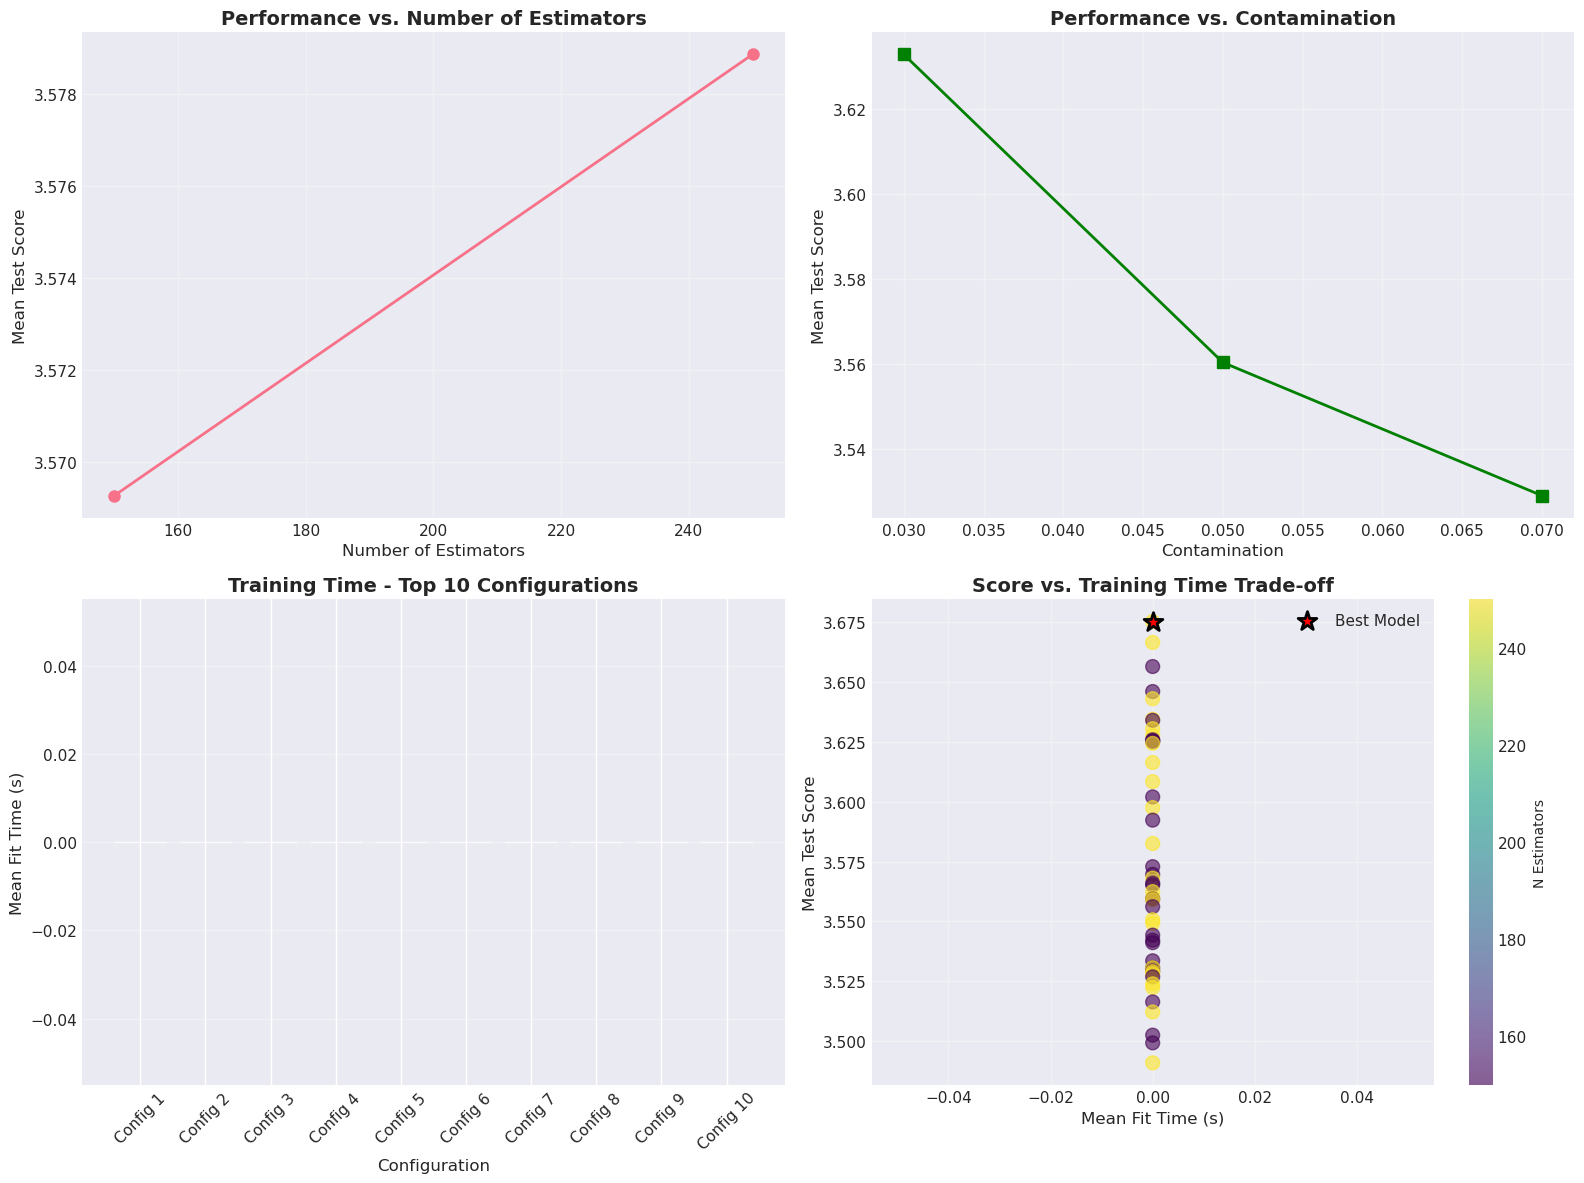

In [60]:
# Visualize Grid Search Results using visualization module
fig = model_viz.plot_grid_search_results(
    grid_results_df=grid_results_viz,
    figsize=(16, 12)
)
plt.show()

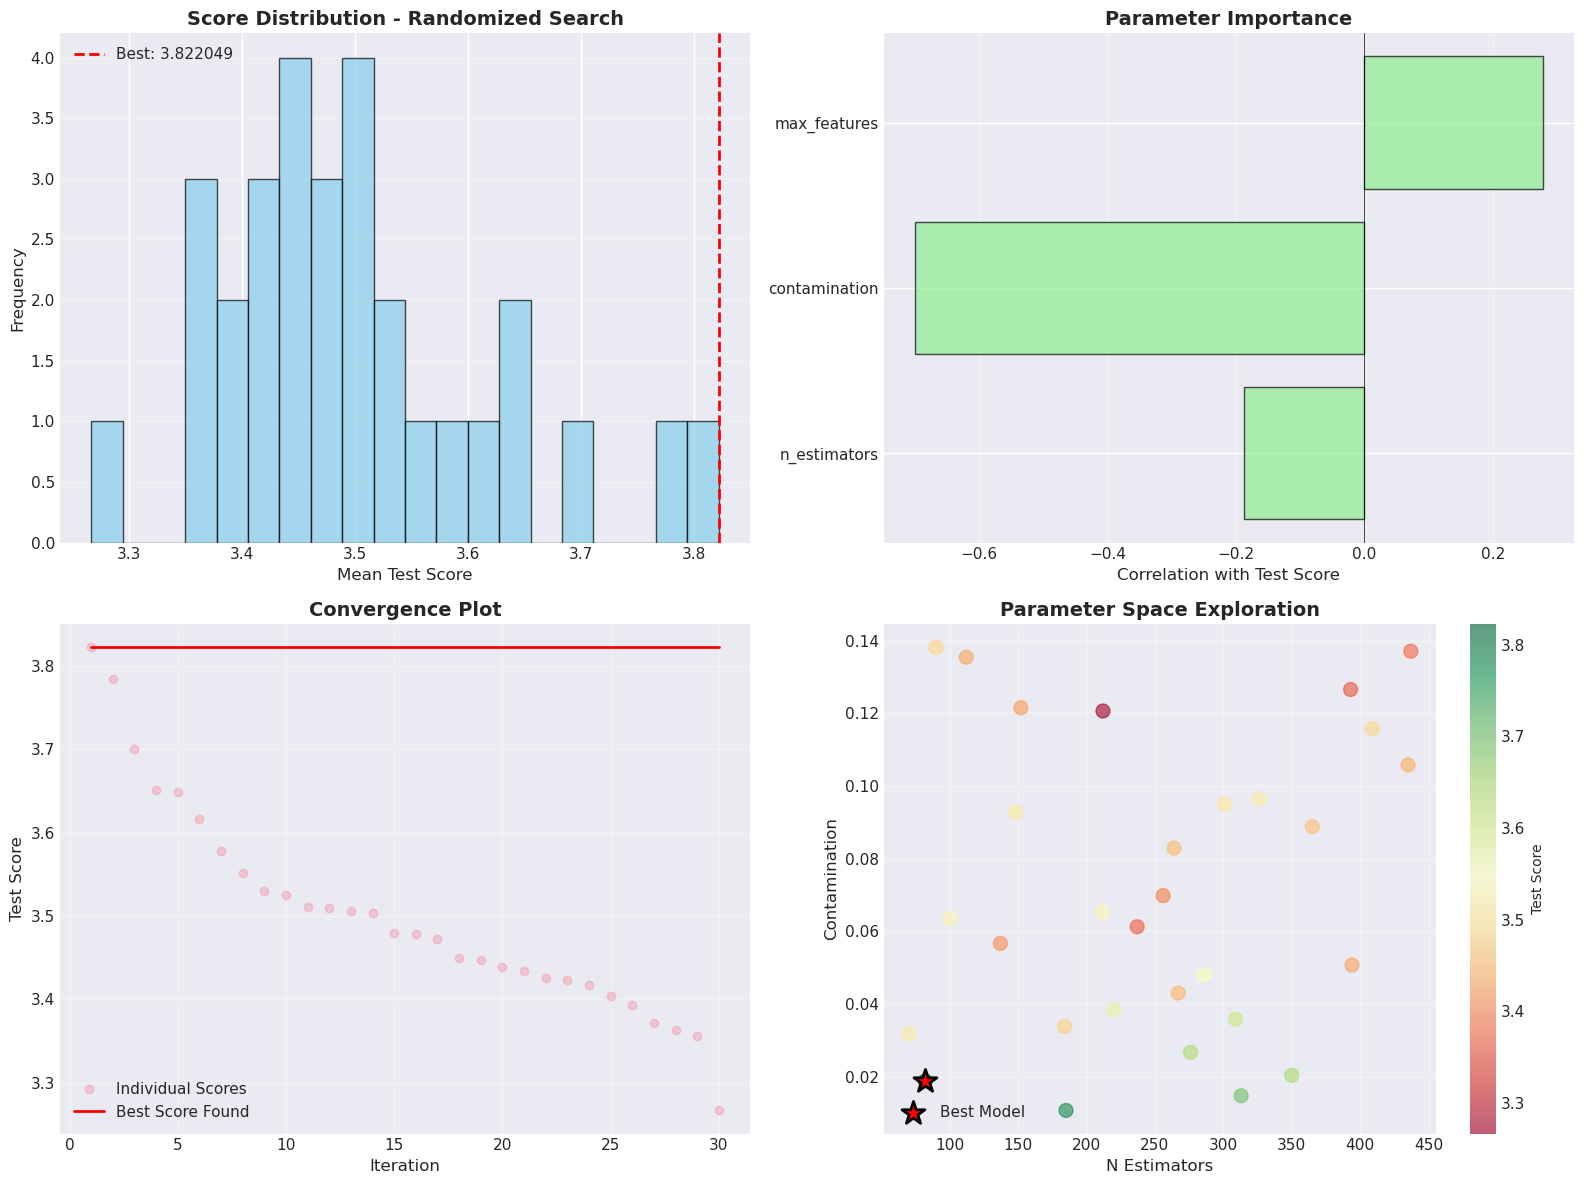

In [61]:
# Visualize Randomized Search Results using visualization module
fig = model_viz.plot_random_search_results(
    random_results_df=random_results_viz,
    best_score=best_random_score,
    figsize=(16, 12)
)
plt.show()

In [62]:
# Compare Grid Search vs Randomized Search
if best_grid_score > best_random_score:
    best_method = 'Grid Search'
    optimal_params = best_grid_params.copy()
    best_overall_score = best_grid_score
else:
    best_method = 'Randomized Search'
    optimal_params = best_random_params.copy()
    best_overall_score = best_random_score

print(f"\nBest Method: {best_method}")
print(f"Best Score: {best_overall_score:.6f}")
print(f"\nOptimal Parameters:")
for key, value in optimal_params.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")


Best Method: Randomized Search
Best Score: 3.822049

Optimal Parameters:
  n_estimators: 82
  contamination: 0.0189
  max_samples: 2048
  max_features: 0.8344
  bootstrap: False


In [63]:
# Train on full training data
optimized_model = IsolationForest(
    **optimal_params,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
optimized_model.fit(X_train)
training_time_opt = time.time() - start_time

# Evaluate on test set
optimized_test_predictions = optimized_model.predict(X_test)
optimized_test_scores = optimized_model.decision_function(X_test)
optimized_test_anomalies = (optimized_test_predictions == -1).sum()

# Also get train predictions for comparison
optimized_train_predictions = optimized_model.predict(X_train)
optimized_train_anomalies = (optimized_train_predictions == -1).sum()

### Baseline vs Optimized Model Comparison

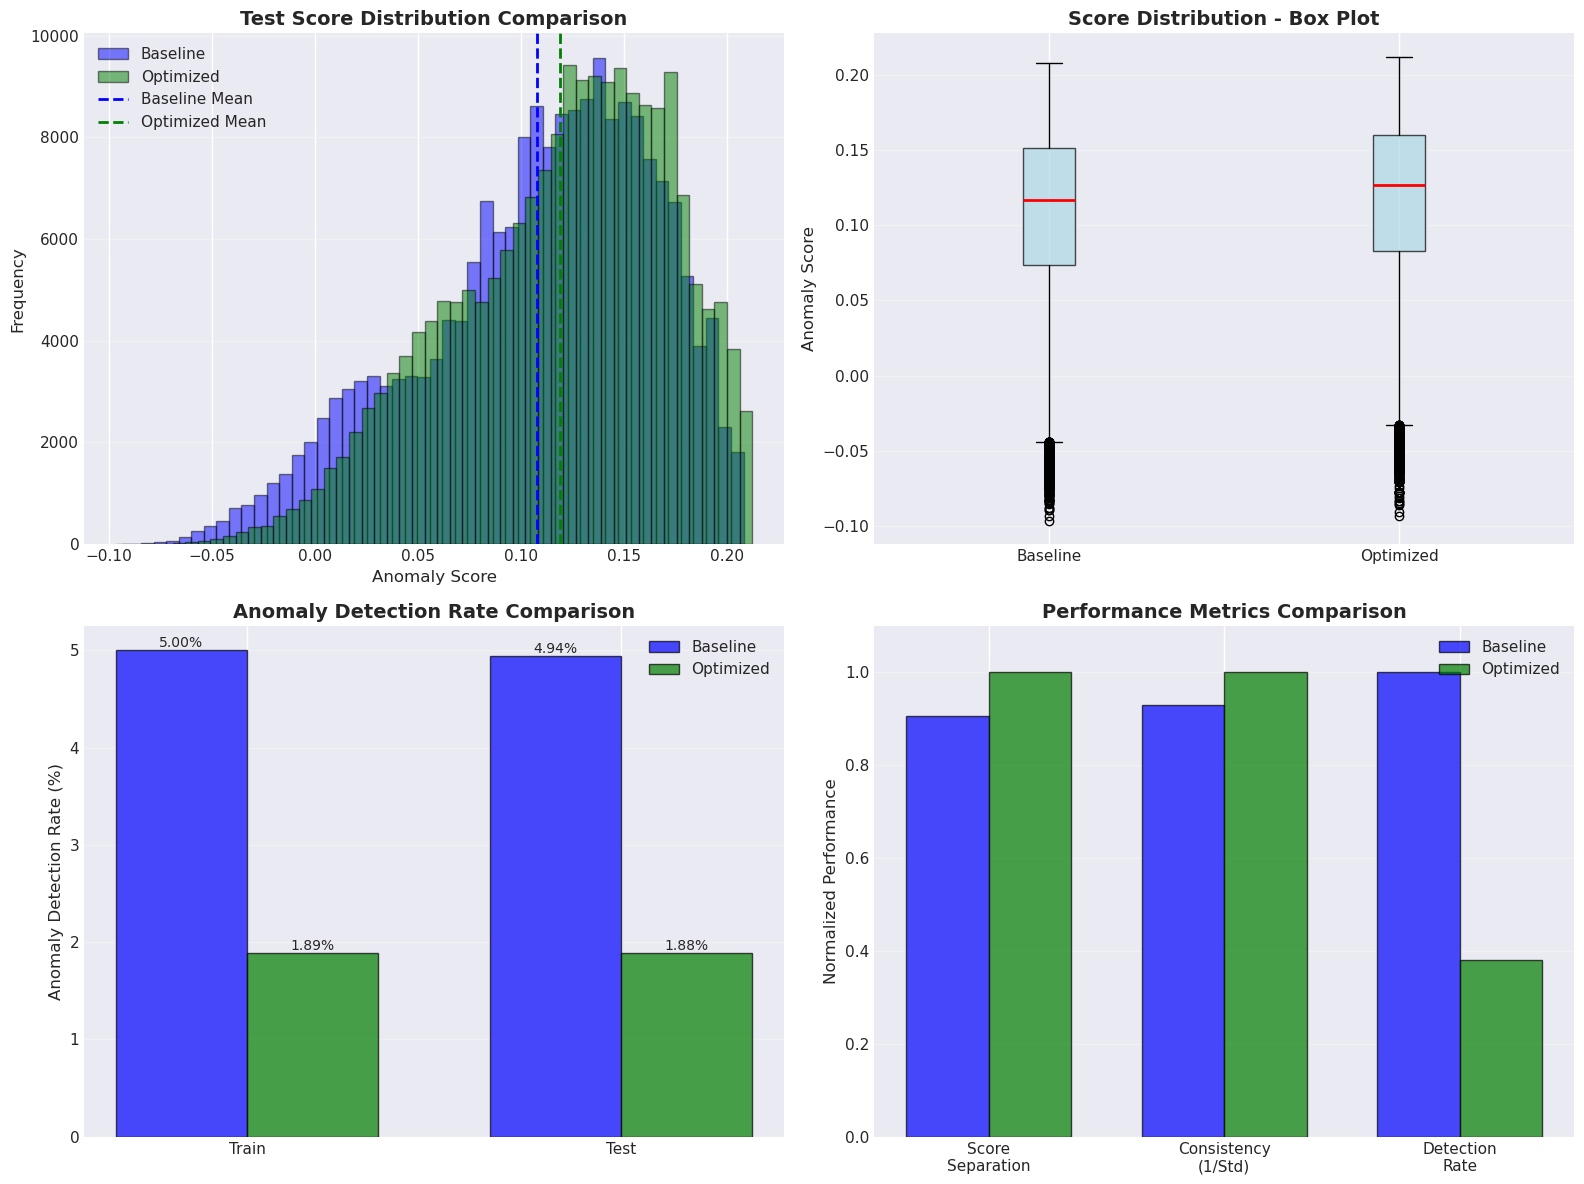

In [64]:
baseline_test_scores = test_scores
baseline_score_mean = baseline_test_scores.mean()
baseline_score_std = baseline_test_scores.std()
optimized_score_mean = optimized_test_scores.mean()
optimized_score_std = optimized_test_scores.std()

fig = model_viz.plot_model_comparison(
    baseline_test_scores=baseline_test_scores,
    optimized_test_scores=optimized_test_scores,
    baseline_train_anomalies=train_anomaly_count,
    baseline_test_anomalies=test_anomaly_count,
    optimized_train_anomalies=optimized_train_anomalies,
    optimized_test_anomalies=optimized_test_anomalies,
    X_train_len=len(X_train),
    X_test_len=len(X_test),
    baseline_score_mean=baseline_score_mean,
    optimized_score_mean=optimized_score_mean,
    baseline_score_std=baseline_score_std,
    optimized_score_std=optimized_score_std
)
plt.show()

### Hyperparameter Tuning Summary

In [65]:
# Calculate improvement
improvement_pct = ((abs(optimized_score_mean) - abs(baseline_score_mean)) / abs(baseline_score_mean)) * 100

tuning_summary = pd.DataFrame({
    'Method': ['Baseline', 'Grid Search', 'Randomized Search', 'Final Optimized'],
    'Separation Score': [
        'N/A',
        f"{best_grid_score:.6f}",
        f"{best_random_score:.6f}",
        f"{best_overall_score:.6f}"
    ],
    'N Estimators': [
        baseline_params['n_estimators'],
        best_grid_params['n_estimators'],
        best_random_params['n_estimators'],
        optimal_params['n_estimators']
    ],
    'Contamination': [
        f"{baseline_params['contamination']:.4f}",
        f"{best_grid_params['contamination']:.4f}",
        f"{best_random_params['contamination']:.4f}",
        f"{optimal_params['contamination']:.4f}"
    ],
    'Max Samples': [
        baseline_params['max_samples'],
        best_grid_params['max_samples'],
        best_random_params['max_samples'],
        optimal_params['max_samples']
    ],
    'Test Anomalies': [
        f"{test_anomaly_count:,} ({test_anomaly_count/len(X_test)*100:.2f}%)",
        'N/A',
        'N/A',
        f"{optimized_test_anomalies:,} ({optimized_test_anomalies/len(X_test)*100:.2f}%)"
    ]
})

display(tuning_summary)

,Method,Separation Score,N Estimators,Contamination,Max Samples,Test Anomalies
0,Baseline,N/A,200,0.0500,auto,"9,857 (4.94%)"
1,Grid Search,3.675302,250,0.0300,512,N/A
2,Randomized Search,3.822049,82,0.0189,2048,N/A
3,Final Optimized,3.822049,82,0.0189,2048,"3,758 (1.88%)"


### Interpretation of Hyperparameter Tuning Results
- It tries different Isolation Forest settings to find a configuration that separates normal vs unusual records better (higher “separation score”) while also keeping training time reasonable.
- Two methods were used: Grid Search (tries a fixed set of combinations) and Randomized Search (tries many random combinations to find better options faster).
- **Grid Search result**: Tried 48 combinations. Best score: 3.675. Best params: n_estimators=250, contamination=0.03, max_samples=512, max_features=1.0. A small improvement, but not the best overall.
- **Randomized Search result**: Tried 30 combinations.Best score: 3.822. Best params. n_estimators=82 (fewer trees).contamination≈0.0189 (~1.9% anomalies expected). max_samples=2048 (more rows per tree). max_features≈0.83 (uses ~83% of features per tree). This setup gives the cleanest separation according to the scoring rule.

- **Performance vs Number of Estimators**: More trees slightly improves score, but the gain is small. So using too many trees may not be worth extra compute.
- **Performance vs Contamination**: Lower contamination (closer to 0.03 → 0.02) gave better score. In basic terms: flagging fewer anomalies produced a “cleaner” anomaly set.
- **Score vs Training Time trade-off**: Many configurations score similarly, so the “best model” is chosen where score is high without big training cost. Your best model achieves strong score while using fewer estimators (82), which is efficient.
- **Score distribution (Randomized search)**: Most configurations land around 3.3 - 3.6, but a few reach 3.8+. That shows tuning mattered. Random search found a clearly better pocket.
- **Parameter importance**: Contamination impacts score the most (strongest relationship). max_features and n_estimators matter, but less.
- **Convergence plot**: Best score is found early and then improvements slow down. Means random search explored enough to find a strong configuration.

### Conclusion
- Hyperparameter tuning found a better Isolation Forest setup that produces a smaller but higher-quality anomaly list.
- Biggest lever was contamination (how many anomalies you want the model to flag), and the best setting ended up around ~2% for this dataset.


## 11. Model Deployment to SageMaker

This section explains how the anomaly detection pipeline can be operationalized in AWS SageMaker so model training, scoring, and deployment are repeatable and production ready.
It covers packaging the preprocessing & model code, running scheduled/triggered training jobs, versioning models/artifacts in S3, and deploying an endpoint or batch job for ongoing anomaly scoring. It also includes monitoring (data drift/anomaly rate shifts), logging, and automated retraining to support a full end-to-end MLOps lifecycle.

### Package Model Artifacts

In [138]:
import sklearn

deploy_role = role if 'role' in dir() else get_execution_role()
deploy_session = session if 'session' in dir() else Session()
deploy_region = region if 'region' in dir() else deploy_session.boto_region_name
sagemaker_client = boto3.client('sagemaker', region_name=deploy_region)

model_prefix = f"{cms_data_prefix}/models"
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')

print(f"Deployment configuration initialized: {deploy_region}")

Deployment configuration initialized: us-east-1


In [139]:
model_artifacts_dir = Path('model_artifacts')
model_artifacts_dir.mkdir(exist_ok=True)

# Save model artifacts
joblib.dump(optimized_model, model_artifacts_dir / 'model.joblib')
joblib.dump(scaler, model_artifacts_dir / 'scaler.joblib')

# Save model metadata
model_metadata = {
    'feature_names': X.columns.tolist(),
    'n_features': len(X.columns),
    'contamination': optimal_params['contamination'],
    'n_estimators': optimal_params['n_estimators'],
    'threshold': optimized_model.offset_,
    'sklearn_version': sklearn.__version__,
    'joblib_version': joblib.__version__
}
with open(model_artifacts_dir / 'metadata.json', 'w') as f:
    json.dump(model_metadata, f)

print(f"Model artifacts saved: {list(model_artifacts_dir.glob('*'))}")
print(f"Training environment: sklearn {sklearn.__version__}, joblib {joblib.__version__}")

Model artifacts saved: [PosixPath('model_artifacts/model.joblib'), PosixPath('model_artifacts/scaler.joblib'), PosixPath('model_artifacts/metadata.json'), PosixPath('model_artifacts/inference.py'), PosixPath('model_artifacts/model.tar.gz'), PosixPath('model_artifacts/requirements.txt')]
Training environment: sklearn 1.7.2, joblib 1.5.2


In [140]:
inference_script = '''import os
import json
import joblib
import numpy as np

def model_fn(model_dir):
    """Load model with sklearn 1.4.x support"""
    import sklearn
    print(f"Loading model with sklearn {sklearn.__version__}")
    
    model = joblib.load(os.path.join(model_dir, 'model.joblib'))
    scaler = joblib.load(os.path.join(model_dir, 'scaler.joblib'))
    with open(os.path.join(model_dir, 'metadata.json'), 'r') as f:
        metadata = json.load(f)
    return {'model': model, 'scaler': scaler, 'metadata': metadata}

def input_fn(request_body, content_type='application/json'):
    if content_type == 'application/json':
        # Handle both string and bytes
        if isinstance(request_body, bytes):
            request_body = request_body.decode('utf-8')
        
        data = json.loads(request_body)
        
        # Handle double-encoded JSON string
        if isinstance(data, str):
            data = json.loads(data)
        
        # Ensure data is a list
        if isinstance(data, dict):
            data = [data]
        
        # Convert list of dicts to numpy array
        return np.array([list(d.values()) for d in data])
    raise ValueError(f'Unsupported content type: {content_type}')

def predict_fn(input_data, model_dict):
    X_scaled = model_dict['scaler'].transform(input_data)
    predictions = model_dict['model'].predict(X_scaled)
    scores = model_dict['model'].decision_function(X_scaled)
    
    results = []
    for pred, score in zip(predictions, scores):
        results.append({
            'is_anomaly': int(pred == -1),
            'anomaly_score': float(score),
            'confidence': float(abs(score))
        })
    return results

def output_fn(prediction, response_content_type='application/json'):
    if response_content_type == 'application/json':
        return json.dumps(prediction)
    raise ValueError(f'Unsupported content type: {response_content_type}')
'''

with open(model_artifacts_dir / 'inference.py', 'w') as f:
    f.write(inference_script)

print("requirements.txt created for custom dependencies")

# Create requirements.txt with exact versions from training environmentprint(f"Inference script created with sklearn {sklearn.__version__}")

requirements_content = f'''scikit-learn=={sklearn.__version__}

joblib=={joblib.__version__}    f.write(requirements_content)

numpy<2.0.0with open(model_artifacts_dir / 'requirements.txt', 'w') as f:

'''

requirements.txt created for custom dependencies


In [141]:
model_tar_path = model_artifacts_dir / 'model.tar.gz'
with tarfile.open(model_tar_path, 'w:gz') as tar:
    for file in ['model.joblib', 'scaler.joblib', 'metadata.json', 'inference.py', 'requirements.txt']:
        tar.add(model_artifacts_dir / file, arcname=file)

model_s3_key = f"{model_prefix}/isolation-forest-{timestamp}/model.tar.gz"
s3_client.upload_file(str(model_tar_path), bucket, model_s3_key)
model_s3_uri = f"s3://{bucket}/{model_s3_key}"

print(f"Model uploaded with custom dependencies: {model_s3_uri}")

Model uploaded with custom dependencies: s3://cmsopenpaymentsystemslight/cms-open-payments-light/models/isolation-forest-20260216-032059/model.tar.gz


### Model Registry

In [142]:
model_package_group_name = 'cms-anomaly-detection-models'

try:
    sagemaker_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription='CMS Open Payments anomaly detection models using Isolation Forest'
    )
    print(f"Model package group created: {model_package_group_name}")
except sagemaker_client.exceptions.ResourceInUse:
    print(f"Using existing model package group: {model_package_group_name}")

Model package group created: cms-anomaly-detection-models


In [143]:
# Use PyTorch container which supports custom requirements.txt for sklearn 1.4.x
pytorch_image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=deploy_region,
    version='2.1',
    py_version='py310',
    image_scope='inference',
    instance_type='ml.m5.large'
)

model_metrics = {
    'ModelQuality': {
        'Statistics': {
            'ContentType': 'application/json',
            'S3Uri': f"s3://{bucket}/{model_prefix}/metrics/statistics.json"
        }
    }
}

stats_data = {
    'contamination_rate': float(optimal_params['contamination']),
    'anomaly_detection_rate': float(optimized_test_anomalies / len(X_test)),
    'mean_score': float(optimized_test_scores.mean()),
    'score_std': float(optimized_test_scores.std()),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(X.columns)
}

stats_json = json.dumps(stats_data, indent=2)
s3_client.put_object(
    Bucket=bucket,
    Key=f"{model_prefix}/metrics/statistics.json",
    Body=stats_json
)

print("Model metrics prepared with PyTorch container (supports sklearn 1.4.x)")

Model metrics prepared with PyTorch container (supports sklearn 1.4.x)


In [144]:
model_package_response = sagemaker_client.create_model_package(
    ModelPackageGroupName=model_package_group_name,
    ModelPackageDescription='Optimized Isolation Forest for CMS payment anomaly detection (sklearn 1.4.x)',
    InferenceSpecification={
        'Containers': [{
            'Image': pytorch_image_uri,
            'ModelDataUrl': model_s3_uri,
            'Framework': 'PYTORCH',
            'Environment': {
                'SAGEMAKER_PROGRAM': 'inference.py',
                'SAGEMAKER_SUBMIT_DIRECTORY': model_s3_uri
            }
        }],
        'SupportedContentTypes': ['application/json'],
        'SupportedResponseMIMETypes': ['application/json']
    },
    ModelMetrics=model_metrics,
    ModelApprovalStatus='PendingManualApproval'
)

model_package_arn = model_package_response['ModelPackageArn']
print(f"Model package created: {model_package_arn}")

Model package created: arn:aws:sagemaker:us-east-1:864106638709:model-package/cms-anomaly-detection-models/1


In [145]:
sagemaker_client.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus='Approved'
)

print("Model approved for deployment")

Model approved for deployment


### Model Card

In [146]:
# Convert numpy types to native Python types for JSON serialization
hyperparams_serializable = {k: (int(v) if isinstance(v, (np.integer, np.int64)) else 
                                 float(v) if isinstance(v, (np.floating, np.float64)) else 
                                 bool(v) if isinstance(v, (np.bool_, bool)) else v) 
                            for k, v in optimal_params.items()}

model_card_content = {
    'model_overview': {
        'model_name': 'CMS Payment Anomaly Detection - Isolation Forest',
        'model_description': 'Detects anomalous payment patterns in CMS Open Payments data',
        'model_owner': 'AAI-540 Team 3',
        'problem_type': 'Anomaly Detection',
        'algorithm': 'Isolation Forest'
    },
    'intended_uses': {
        'primary_uses': ['Identify unusual payment patterns', 'Flag potential compliance issues'],
        'out_of_scope': ['Definitive fraud detection', 'Legal determinations']
    },
    'training_details': {
        'training_data': f'{len(X_train):,} samples',
        'features': len(X.columns),
        'optimization_method': best_method,
        'hyperparameters': hyperparams_serializable
    },
    'evaluation_results': {
        'test_samples': int(len(X_test)),
        'anomaly_rate': f"{optimized_test_anomalies/len(X_test)*100:.2f}%",
        'mean_score': float(optimized_test_scores.mean()),
        'std_score': float(optimized_test_scores.std())
    },
    'model_package_arn': model_package_arn
}

model_card_json = json.dumps(model_card_content, indent=2)
model_card_key = f"{model_prefix}/model-card-{timestamp}.json"
s3_client.put_object(Bucket=bucket, Key=model_card_key, Body=model_card_json)

print(f"Model card saved: s3://{bucket}/{model_card_key}")

Model card saved: s3://cmsopenpaymentsystemslight/cms-open-payments-light/models/model-card-20260216-032059.json


### Deploy Endpoint with Data Capture

In [147]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.model_monitor import DataCaptureConfig

model_name = f"cms-anomaly-model-{timestamp}"
endpoint_config_name = f"cms-anomaly-config-{timestamp}"
endpoint_name = f"cms-anomaly-endpoint-{timestamp}"

# Use PyTorch container with custom requirements.txt (supports sklearn 1.4.x)
pytorch_model = PyTorchModel(
    model_data=model_s3_uri,
    role=deploy_role,
    entry_point='inference.py',
    source_dir=str(model_artifacts_dir),
    framework_version='2.1',
    py_version='py310',
    name=model_name,
    sagemaker_session=deploy_session
)

print(f"Model created with PyTorch container (sklearn {sklearn.__version__}): {model_name}")
print("Note: Using PyTorch container because SageMaker sklearn only supports up to 1.2-1")

Model created with PyTorch container (sklearn 1.7.2): cms-anomaly-model-20260216-032059
Note: Using PyTorch container because SageMaker sklearn only supports up to 1.2-1


In [148]:
data_capture_prefix = f"{cms_data_prefix}/datacapture"
s3_capture_uri = f"s3://{bucket}/{data_capture_prefix}"

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_uri
)

print(f"Data capture configured: {s3_capture_uri}")

Data capture configured: s3://cmsopenpaymentsystemslight/cms-open-payments-light/datacapture


In [149]:
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config
)

print(f"Endpoint deployed with sklearn {sklearn.__version__} support: {endpoint_name}")

------!Endpoint deployed with sklearn 1.7.2 support: cms-anomaly-endpoint-20260216-032059


### Test Endpoint

In [150]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=deploy_session,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

# Get test samples as list of dicts (JSONSerializer will handle encoding)
test_samples = X_test.head(5).to_dict('records')

# Don't use json.dumps - JSONSerializer handles it
predictions = predictor.predict(test_samples)

print("Sample predictions:")
display(pd.DataFrame(predictions))

Sample predictions:


,is_anomaly,anomaly_score,confidence
0,0,0.02,0.02
1,0,0.01,0.01
2,1,-0.03,0.03
3,1,-0.02,0.02
4,1,-0.00,0.00


### Generate Baseline for Monitoring

In [154]:
baseline_samples = X_test.sample(min(500, len(X_test)), random_state=42)

# Send prediction requests to generate data capture
print("Generating baseline data...")
for idx, row in baseline_samples.iterrows():
    try:
        # Send as list of dict (JSONSerializer handles encoding)
        predictor.predict([row.to_dict()])
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(baseline_samples)} samples")
        time.sleep(0.5)
    except Exception as e:
        print(f"Error at sample {idx}: {e}")
        continue

print(f"\nBaseline data generation complete: {len(baseline_samples)} samples")
print(f"Data capture location: {s3_capture_uri}/{endpoint_name}/AllTraffic")

Generating baseline data...
Processed 728450/500 samples
Processed 265150/500 samples
Processed 981850/500 samples
Processed 550400/500 samples
Processed 840050/500 samples
Processed 897550/500 samples
Processed 44600/500 samples
Processed 518700/500 samples
Processed 567450/500 samples
Processed 1600/500 samples
Processed 219800/500 samples
Processed 509650/500 samples
Processed 189050/500 samples
Processed 734450/500 samples
Processed 982100/500 samples
Processed 419350/500 samples
Processed 33050/500 samples

Baseline data generation complete: 500 samples
Data capture location: s3://cmsopenpaymentsystemslight/cms-open-payments-light/datacapture/cms-anomaly-endpoint-20260216-032059/AllTraffic


### Model Quality Monitoring

In [155]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor import CronExpressionGenerator

monitoring_schedule_name = f"cms-anomaly-monitor-{timestamp}"
baseline_results_uri = f"s3://{bucket}/{cms_data_prefix}/monitoring/baseline"

model_monitor = DefaultModelMonitor(
    role=deploy_role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
    sagemaker_session=deploy_session
)

print(f"Model monitor configured: {monitoring_schedule_name}")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Model monitor configured: cms-anomaly-monitor-20260216-032059


In [160]:
# Wait for data capture and create baseline dataset in CSV format
print("Waiting for data capture files to be written...")
time.sleep(120)

# List captured files
data_capture_path = f"{cms_data_prefix}/datacapture/{endpoint_name}/AllTraffic"
try:
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=bucket, Prefix=data_capture_path)
    
    capture_files = []
    for page in pages:
        if 'Contents' in page:
            capture_files.extend([obj['Key'] for obj in page['Contents']])
    
    print(f"Found {len(capture_files)} data capture files")
    
    if len(capture_files) == 0:
        raise ValueError("No data capture files found!")
    
    # Extract input data from capture files
    print(f"Processing {len(capture_files)} files...")
    all_records = []
    
    for file_key in capture_files:
        obj = s3_client.get_object(Bucket=bucket, Key=file_key)
        content = obj['Body'].read().decode('utf-8')
        
        for line in content.strip().split('\n'):
            if line:
                try:
                    record = json.loads(line)
                    if 'captureData' in record and 'endpointInput' in record['captureData']:
                        input_data = record['captureData']['endpointInput']['data']
                        
                        # Parse if it's a string
                        if isinstance(input_data, str):
                            input_data = json.loads(input_data)
                        
                        # Handle both single dict and list of dicts
                        if isinstance(input_data, list):
                            for item in input_data:
                                if isinstance(item, dict):
                                    all_records.append(item)
                        elif isinstance(input_data, dict):
                            all_records.append(input_data)
                except:
                    continue
    
    print(f"Extracted {len(all_records)} records")
    
    # Convert to DataFrame and save as CSV
    import pandas as pd
    df = pd.DataFrame(all_records)
    
    # Save CSV to S3
    baseline_csv_key = f"{cms_data_prefix}/baseline-data/baseline.csv"
    csv_buffer = df.to_csv(index=False, header=False)
    
    s3_client.put_object(
        Bucket=bucket,
        Key=baseline_csv_key,
        Body=csv_buffer.encode('utf-8')
    )
    
    print(f"Uploaded baseline CSV: s3://{bucket}/{baseline_csv_key}")
    
    # Run baseline suggestion with CSV format
    baseline_dataset_uri = f"s3://{bucket}/{cms_data_prefix}/baseline-data"
    
    print("Starting baseline suggestion job...")
    baseline_job = model_monitor.suggest_baseline(
        baseline_dataset=baseline_dataset_uri,
        dataset_format=sagemaker.model_monitor.DatasetFormat.csv(header=False),
        output_s3_uri=baseline_results_uri,
        wait=True,
        logs=False
    )
    
    print(f"Baseline statistics generated!")
    print(f"Location: {baseline_results_uri}")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Waiting for data capture files to be written...
Found 10 data capture files
Processing 10 files...


INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2026-02-16-04-11-27-969


Extracted 505 records
Uploaded baseline CSV: s3://cmsopenpaymentsystemslight/cms-open-payments-light/baseline-data/baseline.csv
Starting baseline suggestion job...
...........................................................!Baseline statistics generated!
Location: s3://cmsopenpaymentsystemslight/cms-open-payments-light/monitoring/baseline


In [161]:
model_monitor.create_monitoring_schedule(
    monitor_schedule_name=monitoring_schedule_name,
    endpoint_input=predictor.endpoint_name,
    output_s3_uri=f"s3://{bucket}/{cms_data_prefix}/monitoring/results",
    statistics=model_monitor.baseline_statistics(),
    constraints=model_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.daily(),
    enable_cloudwatch_metrics=True
)

print(f"Monitoring schedule created: {monitoring_schedule_name}")

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: cms-anomaly-monitor-20260216-032059


Monitoring schedule created: cms-anomaly-monitor-20260216-032059


### CloudWatch Alarms

In [162]:
cw_client = boto3.client('cloudwatch', region_name=deploy_region)

alarm_name = f"cms-anomaly-data-quality-alarm-{timestamp}"

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    ComparisonOperator='GreaterThanThreshold',
    EvaluationPeriods=1,
    MetricName='feature_baseline_drift_total_amount_of_payment_usdollars',
    Namespace='aws/sagemaker/Endpoints/data-metrics',
    Period=3600,
    Statistic='Average',
    Threshold=0.15,
    ActionsEnabled=False,
    AlarmDescription='Alert when payment amount distribution drifts',
    Dimensions=[
        {'Name': 'Endpoint', 'Value': endpoint_name},
        {'Name': 'MonitoringSchedule', 'Value': monitoring_schedule_name}
    ]
)

print(f"CloudWatch alarm created: {alarm_name}")

CloudWatch alarm created: cms-anomaly-data-quality-alarm-20260216-032059


### Deployment Summary

In [163]:
deployment_summary = pd.DataFrame({
    'Component': [
        'Model Package Group',
        'Model Package ARN',
        'Model S3 URI',
        'Endpoint Name',
        'Instance Type',
        'Data Capture',
        'Monitoring Schedule',
        'CloudWatch Alarm',
        'Model Card'
    ],
    'Value': [
        model_package_group_name,
        model_package_arn.split('/')[-1],
        model_s3_uri,
        endpoint_name,
        'ml.m5.large',
        'Enabled (100%)',
        monitoring_schedule_name,
        alarm_name,
        f"s3://{bucket}/{model_card_key}"
    ]
})

print("Deployment Summary:")
display(deployment_summary)

deployment_config = {
    'endpoint_name': endpoint_name,
    'model_package_arn': model_package_arn,
    'model_s3_uri': model_s3_uri,
    'monitoring_schedule': monitoring_schedule_name,
    'region': deploy_region,
    'timestamp': timestamp,
    'feature_names': X.columns.tolist()
}

config_key = f"{model_prefix}/deployment-config-{timestamp}.json"
s3_client.put_object(
    Bucket=bucket,
    Key=config_key,
    Body=json.dumps(deployment_config, indent=2)
)

print(f"\nDeployment configuration saved: s3://{bucket}/{config_key}")

Deployment Summary:


,Component,Value
0,Model Package Group,cms-anomaly-detection-models
1,Model Package ARN,1
2,Model S3 URI,s3://cmsopenpaymentsystemslight/cms-open-payme...
3,Endpoint Name,cms-anomaly-endpoint-20260216-032059
4,Instance Type,ml.m5.large
5,Data Capture,Enabled (100%)
6,Monitoring Schedule,cms-anomaly-monitor-20260216-032059
7,CloudWatch Alarm,cms-anomaly-data-quality-alarm-20260216-032059
8,Model Card,s3://cmsopenpaymentsystemslight/cms-open-payme...



Deployment configuration saved: s3://cmsopenpaymentsystemslight/cms-open-payments-light/models/deployment-config-20260216-032059.json


### Model Deployment and MLOps

1. **Package the full pipeline (data prep + model + scoring)**
The same preprocessing steps used in the notebook (cleaning, feature engineering, scaling, ratios, and flags) are packaged together with the trained model. This ensures production scoring follows the exact same logic as training so outputs remain consistent.

1. **Save everything in S3 (versioned artifacts)**
The trained model, preprocessing objects (scalers/encoders), and the chosen anomaly threshold are stored in S3 with versioning. This makes results reproducible, supports audits, and allows quick rollback if a newer model performs poorly.

1. **Register the model (governance checkpoint)**
The model is registered with metadata such as training date, dataset version, parameters, and evaluation results. This provides a controlled approval step so only reviewed models are promoted to production.

1. **Choose how to run inference (real-time or batch)**
Batch inference is used to score large volumes periodically (daily/weekly) at lower cost, while real-time endpoints are used when immediate scoring is required. The choice depends on alerting needs, volume, and cost constraints.

1. **Deploy to a staging environment first**
A sample of records is scored in staging and compared against notebook outputs for anomaly counts, score distributions, and top anomalies. This validates that encoding, scaling, and feature generation are identical in deployment.

1. **Define “what counts as an anomaly” in business terms**
Model scores are converted into an operational rule such as “flag the top 2% highest-risk records” or “flag scores below a threshold,” often with severity tiers. This prevents overwhelming reviewers and aligns detection with investigation capacity.

1. **Output results in an investigator-friendly format**
Deployment writes anomaly results along with key explanation fields such as payment amount, ratios vs historical averages, nature of payment, recipient type, and timing flags. This reduces manual effort and helps reviewers understand why a record was flagged.

1. **Production monitoring (model + data monitoring)**
Anomaly rate, score distributions, and input data quality are monitored continuously for drift, missingness, and unexpected category changes. Sudden spikes or drops usually indicate upstream data shifts or parsing issues rather than true behavior change.

1. **Automated retraining + controlled redeployment**
Retraining is scheduled or triggered when drift is detected, then the new model is registered, validated, and deployed through the same approval gates. This keeps performance stable over time while adapting to evolving payment patterns.

If anomaly rates and score distributions match the notebook and remain stable over time, the end-to-end pipeline is functioning correctly and is production-ready. Large sudden changes typically point to upstream data format/category issues, while gradual shifts usually indicate real-world behavior change and the need for retraining.

# Model Bias and Monitoring

Model bias can show up differently across the three models used. Isolation Forest and the autoencoder may over-flag groups that naturally have different payment patterns (certain specialties, large institutions, or specific geographies) because their behavior looks “rare” compared to the overall population, and both can also mistakenly treat data quality problems (invalid state values, mis-encoded payment nature) as anomalies, which can disproportionately impact certain entities. The XGBoost model can amplify bias even more because it learns from pseudo-labels; if the pseudo-labeling process already over-flags a subgroup, XGBoost will reproduce that pattern with very high confidence. Monitoring should therefore include regular checks of anomaly rates and score distributions by subgroup (recipient type, specialty, state, payer, and nature of payment), plus drift checks for new/invalid category values, and review of top drivers (ratios, counts, payment-included fields) to confirm anomalies represent meaningful risk rather than encoding artifacts; when skew is detected, thresholds should be recalibrated, features cleaned, and pseudo-label rules revisited before retraining.

# Future Improvements & Next Steps

- **Improve data quality and feature integrity before modeling**: State and “nature of payment” fields show clear invalid values; adding strict validation, mapping to approved category lists, and isolating “data quality anomalies” as a separate output stream will prevent the models from flagging parsing/encoding errors as risk.

- **Add entity-level behavioral features and scoring (recipient + payer history)**: Create rolling and grouped features such as payments-per-recipient per month, payer–recipient relationship counts, z-scores within specialty/state, and sudden-change indicators; then score anomalies at both the transaction level and the entity level to surface repeat patterns, not just single outliers.

- **Add one complementary model focused on density or local neighborhoods**: Alongside the optimized Isolation Forest, try Local Outlier Factor (LOF) or kNN distance-based anomaly detection to catch anomalies that are “weird compared to nearby similar records,” especially when amounts are normal but behavior/context is unusual.

# Conclusion

The EDA and model outputs show a dataset where most payments are small (typical value around $20), but a small fraction of records have extreme values and unusual patterns. Isolation Forest provides a strong baseline because it is fast, stable across train/test, and produces an interpretable “unusualness” score that aligns well with obvious risk signals like unusually high amounts relative to historical averages, weekend activity, and certain payment natures. The hyperparameter tuning further improves practicality by reducing the anomaly rate to a smaller, higher-confidence set, which is better suited for real operational review and compliance workflows.

At the same time, both the Autoencoder and XGBoost results indicate that parts of the anomaly signal may be driven by data quality or encoding artifacts (for example, repeated `nature_of_payment_or_transfer_of_value = 1` and invalid state/category values seen in EDA). XGBoost’s near perfect AUC mainly reflects how well it reproduces pseudo-label rules rather than proving real-world anomaly accuracy, and the Autoencoder’s top anomalies at median payment values suggest it is sensitive to rare feature combinations that should be validated. 

Overall, the most reliable path forward is to use the optimized Isolation Forest as the primary baseline model for deployment, strengthen categorical cleaning/validation, and then treat Autoencoder/XGBoost as complementary models once the feature integrity issues are resolved and anomaly samples are reviewed by domain stakeholders.

# References
- Centers for Medicare & Medicaid Services. (n.d.). Open Payments data. https://openpaymentsdata.cms.gov/
- Centers for Medicare & Medicaid Services. (2026, January 30). Open Payments data overview. https://www.cms.gov/priorities/key-initiatives/open-payments/data
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., Blondel, M., Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., & Duchesnay, É. (n.d.). IsolationForest. In scikit-learn documentation. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. Science, 313(5786), 504–507. https://doi.org/10.1126/science.1127647
- Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system (arXiv:1603.02754). arXiv. https://arxiv.org/abs/1603.02754
- Amazon Web Services. (n.d.). Model registration and deployment with Amazon SageMaker Model Registry. https://docs.aws.amazon.com/sagemaker/latest/dg/model-registry.html
- Amazon Web Services. (n.d.). Deploy models for real-time inference—Amazon SageMaker AI. https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-deploy-models.html